# Boosting Algorithms' Application in Ashare Stock Market in China

## content  
- [Introduction of XGboost, Adaboost and GBDT](#a)  
- [Obtaining data](#b)  
- [Generate data about return](#c)  
- [Merge all data and transform factor data into panal data](#d)  
- [Deleting ST,not on-list and standardlization](#e)   
- [Label the data](#f)  
- [XGBOOST](#g)  
- [Adaboost](#h)  
- [GBDT](#i)
- [Boosting with parameter optimization](#j)    
  - [XGBOOST](#k)    
  - [Adaboost](#l)    
  - [GBDT](#m)  
- [Backtest](#n)  

<a id='a'></a>  
## Introduction of XGboost, Adaboost, and GBDT  
### Adaboost  
AdaBoost uses the complete training dataset to train the weak learners, where the training examples are reweighted in each iteration to build a strong classifier that learns from the mistakes of the previous weak learners in the ensemble.  
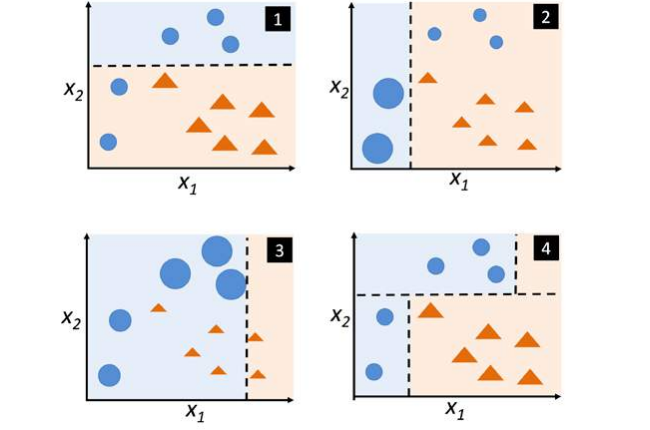  
We start with subfigure 1, which represents a training dataset for binary classification where all training examples are assigned equal weights. Based on this training dataset, we train a decision stump (shown as a dashed line) that tries to classify the examples of the two classes (triangles and circles), as well as possibly minimizing the cost function (or the impurity score in the special case of decision tree ensembles).  
For the next round (subfigure 2), we assign a larger weight to the two previously misclassified examples (circles). Furthermore, we lower the weight of the correctly classified examples. The next decision stump will now be more focused on the training examples that have the largest weights—the training examples that are supposedly hard to classify. The weak learner shown in subfigure 2 misclassifies three different examples from the circle class, which are then assigned a larger weight, as shown in subfigure 3.  
Assuming that our AdaBoost ensemble only consists of three rounds of boosting, we then combine the three weak learners trained on different reweighted training subsets by a weighted majority vote, as shown in subfigure 4.  
### GBDT  
GBDT(Gradient Boosting Decision Tree):It bases on CART regression tree.Every time it uses the residual of previous weak model to train a new CART regression tree and the residual is the negative garadient of the loss function.The algrithm is as follwing.  
1.Initialize the weak learning   
  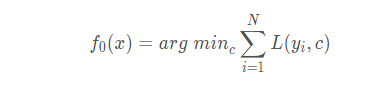  
2.Calculate the residual for evry sample and to get (xi,rim).   
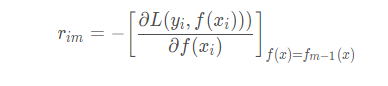
m denotes the mth model    
3.Use the residual to train the next weak model  
 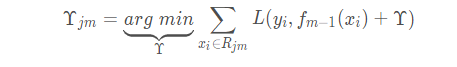  
 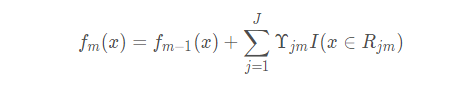  
 j denots the jth leaf area.  
4.Form the final strong leaning model.    
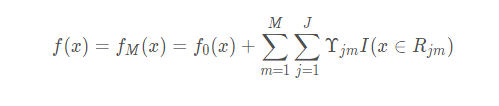  
### XGBOOST  
XGBOOST is an improvement of GBDT.It uses the residual of the fommer model to tarin the next model, the reason we choose XGBoost is that it is more effecient.    
The procedure picture of XGBOOST  
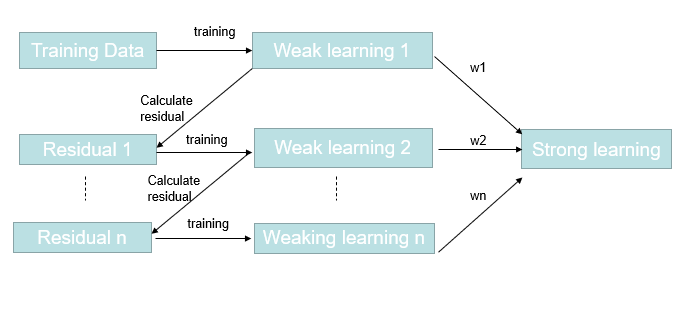


<a id='b'></a>  
## Obtaining data

Based on the reference of the research report given by Huatai Security and the actual situation, we will focus on the period from 2010 to 2020.\
In this project, due to the giant demand of data, our team members first use **Wind** to collect the data of valuation factors and return rates of Ashares.Then we use **Filesync**(which is the underlying database of **Wind**) to gain financial factors, technical factors and other factors as there is withdrawal limit of Wind in Finlab. **The code with account-information will be omit**.

### Gaining the last trade date each month

We will show most of our code gaining data from FileSync. We use the month-frequency data to train the model so we should get the last trade date of each month.

In [1]:
import pandas as pd
import numpy as np
import time
import datetime
from pandas.core.frame import DataFrame

In [2]:
import cx_Oracle

First we gain trade dates in our period.

In [5]:
testSql='SELECT Trade_days FROM FILESYNC.AShareCalendar WHERE Trade_days BETWEEN 20091201 AND 20210220 '
cursor=conn.cursor()
cursor.execute(testSql)
result=cursor.fetchall()
result.sort()
result

[('20091201',),
 ('20091201',),
 ('20091202',),
 ('20091202',),
 ('20091203',),
 ('20091203',),
 ('20091204',),
 ('20091204',),
 ('20091207',),
 ('20091207',),
 ('20091208',),
 ('20091208',),
 ('20091209',),
 ('20091209',),
 ('20091210',),
 ('20091210',),
 ('20091211',),
 ('20091211',),
 ('20091214',),
 ('20091214',),
 ('20091215',),
 ('20091215',),
 ('20091216',),
 ('20091216',),
 ('20091217',),
 ('20091217',),
 ('20091218',),
 ('20091218',),
 ('20091221',),
 ('20091221',),
 ('20091222',),
 ('20091222',),
 ('20091223',),
 ('20091223',),
 ('20091224',),
 ('20091224',),
 ('20091225',),
 ('20091225',),
 ('20091228',),
 ('20091228',),
 ('20091229',),
 ('20091229',),
 ('20091230',),
 ('20091230',),
 ('20091231',),
 ('20091231',),
 ('20100104',),
 ('20100104',),
 ('20100105',),
 ('20100105',),
 ('20100106',),
 ('20100106',),
 ('20100107',),
 ('20100107',),
 ('20100108',),
 ('20100108',),
 ('20100111',),
 ('20100111',),
 ('20100112',),
 ('20100112',),
 ('20100113',),
 ('20100113',),
 ('20100

In [6]:
td=DataFrame(result)
td.columns=['date']
td.drop_duplicates(inplace=True)
td['tdate']=pd.to_datetime(td['date'],format='%Y%m%d')
td['year']=td['tdate'].dt.year
td['month']=td['tdate'].dt.month
td

,date,tdate,year,month
0,20091201,2009-12-01,2009,12
2,20091202,2009-12-02,2009,12
4,20091203,2009-12-03,2009,12
6,20091204,2009-12-04,2009,12
8,20091207,2009-12-07,2009,12
...,...,...,...,...
7862,20210208,2021-02-08,2021,2
7866,20210209,2021-02-09,2021,2
7870,20210210,2021-02-10,2021,2
7874,20210218,2021-02-18,2021,2


Now we use **pd.groupby()** to gain the last trade date of each month.

In [7]:
trade_date=td.groupby(['year','month']).last()
trade_date=trade_date.reset_index()[['date']]
trade_date.drop([len(trade_date)-1],inplace=True)
trade_date

,date
0,20091231
1,20100129
2,20100226
3,20100331
4,20100430
...,...
129,20200930
130,20201030
131,20201130
132,20201231


In [8]:
trade_date.to_csv('trade_date.csv')

Then we gain report dates in our period.

In [9]:
testSql='SELECT REPORT_PERIOD FROM FILESYNC.AShareFinancialIndicator WHERE REPORT_PERIOD BETWEEN 20100101 AND 20210101 '
cursor=conn.cursor()
cursor.execute(testSql)
result2=cursor.fetchall()
result2.sort()
result2

[('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100331',),
 ('20100

In [10]:
report_period=DataFrame(result2)
report_period.columns=['report period']
report_period.drop_duplicates(inplace=True)

In [11]:
rp=tuple(report_period['report period'].astype(int).values)

In [12]:
rp

(20100331,
 20100630,
 20100930,
 20101231,
 20110331,
 20110630,
 20110930,
 20111231,
 20120331,
 20120630,
 20120930,
 20121031,
 20121231,
 20130331,
 20130630,
 20130731,
 20130930,
 20131231,
 20140331,
 20140430,
 20140531,
 20140630,
 20140731,
 20140831,
 20140930,
 20141031,
 20141231,
 20150331,
 20150430,
 20150531,
 20150630,
 20150731,
 20150831,
 20150930,
 20151031,
 20151130,
 20151231,
 20160131,
 20160229,
 20160331,
 20160430,
 20160531,
 20160630,
 20160831,
 20160930,
 20161031,
 20161130,
 20161231,
 20170131,
 20170331,
 20170531,
 20170630,
 20170731,
 20170831,
 20170930,
 20171031,
 20171231,
 20180131,
 20180331,
 20180630,
 20180930,
 20181231,
 20190331,
 20190430,
 20190630,
 20190731,
 20190831,
 20190930,
 20191231,
 20200331,
 20200430,
 20200630,
 20200930,
 20201231)

### Generating stock data

After gaining the monthly-frequency trade dates, we can extract data of these dates from FileSync. For each table of FileSync, We can not gain  more than 60 dates or more than 10 fields for one time, so we have to write loops to gain our data.

In [13]:
td=tuple(trade_date['date'].astype(int).values)

In [14]:
t1=td[0:50]
t2=td[50:100]
t3=td[100:134]

In [15]:
tdate=(t1,t2,t3)

### Data1(AShareTechIndicators)

In [134]:
factor1=',VOLUME_RATIO_5D,VAM_1M,VAM_5M,VAM_60M,VMACD_MACD,TAPI_16D,VROC_12D'

In [135]:
df1=pd.DataFrame(columns=[0,1,2,3,4,5,6,7,8])

In [136]:
for i in range(len(tdate)):
    testSql_1=f'SELECT s_info_windcode,TRADE_DT{factor1} FROM FILESYNC.AShareTechIndicators WHERE TRADE_DT IN {tdate[i]}'
    cursor.execute(testSql_1)
    result_1=cursor.fetchall()
    df1=df1.append(result_1)

In [137]:
df1.to_csv('df1.csv')

### Data2(AshareintensitytrendADJ)

In [19]:
factor2=',MARKET,BOTTOMING_D,DMI_ADXR,MACD_DIFF,MACD_DEA,MACD_MACD,MTM_MTMMA'

In [20]:
df2=pd.DataFrame(columns=[0,1,2,3,4,5,6,7,8])

In [21]:
for i in range(len(tdate)):
    testSql_2=f'SELECT s_info_windcode,TRADE_DT{factor2} FROM FILESYNC.AshareintensitytrendADJ WHERE TRADE_DT IN {tdate[i]}'
    cursor.execute(testSql_2)
    result_2=cursor.fetchall()
    df2=df2.append(result_2)
df2.to_csv('df2.csv')

### Data3(AShareEnergyindexADJ)

In [193]:
factor3=',CDP,MIKE_WR,PVT,ARBR_AR,ARBR_BR,PSY,PSYMA'

In [194]:
df3=pd.DataFrame(columns=[0,1,2,3,4,5,6,7,8])

In [195]:
for i in range(len(tdate)):
    testSql_3=f'SELECT s_info_windcode,TRADE_DT{factor3} FROM FILESYNC.AShareEnergyindexADJ WHERE TRADE_DT IN {tdate[i]}'
    cursor.execute(testSql_3)
    result_3=cursor.fetchall()
    df3=df3.append(result_3)
df3.to_csv('df3.csv')

### Data4(AShareswingReversetrendADJ)

In [25]:
factor4=',ADTM_ADTMMA,BIAS,KDJ_D,RSI,WR,BIAS36,BIAS612'

In [26]:
df4=pd.DataFrame(columns=[0,1,2,3,4,5,6,7,8])

In [27]:
for i in range(len(tdate)):
    testSql_4=f'SELECT s_info_windcode,TRADE_DT{factor4} FROM FILESYNC.AShareswingReversetrendADJ WHERE TRADE_DT IN {tdate[i]}'
    cursor.execute(testSql_4)
    result_4=cursor.fetchall()
    df4=df4.append(result_4)
df4.to_csv('df4.csv')

Unfortunately, there are almost only data after 2018 for Data1 to Data4, so we may not use it later.

### Data5(AShareFinancialIndicator-1)

In [28]:
factor5=',S_FA_GROSSPROFITMARGIN,S_FA_ROE,S_FA_ROE_DEDUCTED,S_FA_ROA2,S_FA_ROA,S_FA_OCFTOOPERATEINCOME'

In [29]:
df5=pd.DataFrame(columns=[0,1,2,3,4,5,6,7])

In [30]:
testSql_5=f'SELECT s_info_windcode,REPORT_PERIOD{factor5} FROM FILESYNC.AShareFinancialIndicator WHERE REPORT_PERIOD IN {rp}'
cursor.execute(testSql_5)
result_5=cursor.fetchall()
df5=df5.append(result_5)
df5.to_csv('df5.csv')

### Data6(AShareFinancialIndicator-2)

In [31]:
factor6=',S_FA_ASSETSTOEQUITY,S_FA_CURRENT,S_FA_CASHRATIO,S_FA_ASSETSTURN,S_FA_YOYOCFPS,S_FA_YOYOP'

In [32]:
df6=pd.DataFrame(columns=[0,1,2,3,4,5,6,7])

In [33]:
testSql_6=f'SELECT s_info_windcode,REPORT_PERIOD{factor6} FROM FILESYNC.AShareFinancialIndicator WHERE REPORT_PERIOD IN {rp}'
cursor.execute(testSql_6)
result_6=cursor.fetchall()
df6=df6.append(result_6)
df6.to_csv('df6.csv')

### Data7(AShareFinancialIndicator-3)

In [34]:
factor7=',S_FA_YOYEBT,S_FA_YOYNETPROFIT,S_FA_YOYNETPROFIT_DEDUCTED,S_FA_YOYOCF,S_FA_YOYROE,S_FA_YOY_OR'

In [35]:
df7=pd.DataFrame(columns=[0,1,2,3,4,5,6,7])

In [36]:
testSql_7=f'SELECT s_info_windcode,REPORT_PERIOD{factor7} FROM FILESYNC.AShareFinancialIndicator WHERE REPORT_PERIOD IN {rp}'
cursor.execute(testSql_7)
result_7=cursor.fetchall()
df7=df7.append(result_7)
df7.to_csv('df7.csv')

### Data8(AShareMonthlyYield)

In [37]:
factor8=',S_MQ_AVGTURN,S_MQ_DEVPCTCHANGE24,S_MQ_DEVPCTCHANGE60'

In [38]:
df8=pd.DataFrame(columns=[0,1,2,3,4])

In [39]:
for i in range(len(tdate)):
    testSql_8=f'SELECT s_info_windcode,TRADE_DT{factor8} FROM FILESYNC.AShareMonthlyYield WHERE TRADE_DT IN {tdate[i]}'
    cursor.execute(testSql_8)
    result_8=cursor.fetchall()
    df8=df8.append(result_8)
df8.to_csv('df8.csv')

<a id='c'></a>  
##  Generate data about return

### Generating absolute return next month

In [62]:
pd.read_csv('close.csv')

,ticker,20091231,20100129,20100226,20100331,20100430,20100531,20100630,20100730,20100831,...,20200430,20200529,20200630,20200731,20200831,20200930,20201030,20201130,20201231,20210129
0,000001.SZ,24.37,21.70,22.45,23.20,20.56,17.51,17.51,17.51,17.51,...,13.93,13.00,12.80,13.34,15.08,15.17,17.75,19.74,19.34,23.09
1,000002.SZ,10.81,9.34,9.43,9.50,7.80,7.21,6.78,8.29,8.42,...,26.80,25.70,26.14,26.84,27.27,28.02,27.55,30.70,28.70,27.79
2,000004.SZ,10.00,10.00,10.36,11.38,10.36,9.00,8.43,9.63,11.31,...,27.68,28.88,29.84,28.68,25.58,23.09,26.60,27.62,20.70,20.26
3,000005.SZ,6.02,5.39,5.59,5.96,4.79,4.36,3.83,4.67,4.87,...,2.68,2.57,2.63,2.92,2.94,2.58,2.53,2.58,2.53,2.14
4,000006.SZ,11.33,9.96,10.38,11.97,9.52,5.46,5.16,8.93,8.18,...,4.99,4.81,6.81,8.28,6.39,6.43,5.72,5.73,5.61,4.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4531,689009.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,47.60,71.35,85.82,100.28
4532,834765.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.00,8.00,10.00,12.00,12.37,12.00,12.00,12.00,12.00,12.00
4533,836433.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
close=pd.read_csv('close.csv').iloc[0:4534,:].set_index('ticker')

In [64]:
close1=close.shift(1,axis=1)
close1

,20091231,20100129,20100226,20100331,20100430,20100531,20100630,20100730,20100831,20100930,...,20200430,20200529,20200630,20200731,20200831,20200930,20201030,20201130,20201231,20210129
ticker,,,,,,,,,,,,,,,,,,,,,
000001.SZ,NaN,24.37,21.70,22.45,23.20,20.56,17.51,17.51,17.51,17.51,...,12.80,13.93,13.00,12.80,13.34,15.08,15.17,17.75,19.74,19.34
000002.SZ,NaN,10.81,9.34,9.43,9.50,7.80,7.21,6.78,8.29,8.42,...,25.65,26.80,25.70,26.14,26.84,27.27,28.02,27.55,30.70,28.70
000004.SZ,NaN,10.00,10.00,10.36,11.38,10.36,9.00,8.43,9.63,11.31,...,30.51,27.68,28.88,29.84,28.68,25.58,23.09,26.60,27.62,20.70
000005.SZ,NaN,6.02,5.39,5.59,5.96,4.79,4.36,3.83,4.67,4.87,...,2.74,2.68,2.57,2.63,2.92,2.94,2.58,2.53,2.58,2.53
000006.SZ,NaN,11.33,9.96,10.38,11.97,9.52,5.46,5.16,8.93,8.18,...,4.48,4.99,4.81,6.81,8.28,6.39,6.43,5.72,5.73,5.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688819.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688981.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,82.21,66.68,49.65,62.24,59.25,57.75
689009.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.60,71.35,85.82


In [65]:
rate=(close-close1)/close1
rate

,20091231,20100129,20100226,20100331,20100430,20100531,20100630,20100730,20100831,20100930,...,20200430,20200529,20200630,20200731,20200831,20200930,20201030,20201130,20201231,20210129
ticker,,,,,,,,,,,,,,,,,,,,,
000001.SZ,NaN,-0.109561,0.034562,0.033408,-0.113793,-0.148346,0.000000,0.000000,0.000000,-0.073672,...,0.088281,-0.066762,-0.015385,0.042187,0.130435,0.005968,0.170073,0.112113,-0.020263,0.193899
000002.SZ,NaN,-0.135985,0.009636,0.007423,-0.178947,-0.075641,-0.059639,0.222714,0.015682,-0.002375,...,0.044834,-0.041045,0.017121,0.026779,0.016021,0.027503,-0.016774,0.114338,-0.065147,-0.031707
000004.SZ,NaN,0.000000,0.036000,0.098456,-0.089631,-0.131274,-0.063333,0.142349,0.174455,0.007073,...,-0.092756,0.043353,0.033241,-0.038874,-0.108089,-0.097342,0.152014,0.038346,-0.250543,-0.021256
000005.SZ,NaN,-0.104651,0.037106,0.066190,-0.196309,-0.089770,-0.121560,0.219321,0.042827,-0.102669,...,-0.021898,-0.041045,0.023346,0.110266,0.006849,-0.122449,-0.019380,0.019763,-0.019380,-0.154150
000006.SZ,NaN,-0.120918,0.042169,0.153179,-0.204678,-0.426471,-0.054945,0.730620,-0.083987,-0.096577,...,0.113839,-0.036072,0.415800,0.215859,-0.228261,0.006260,-0.110420,0.001748,-0.020942,-0.133690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688819.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688981.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.188906,-0.255399,0.253575,-0.048040,-0.025316,-0.027186
689009.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.498950,0.202803,0.168492


In [66]:
next_month_return=rate.shift(-1,axis=1).drop(columns=['20091231','20210129'])
next_month_return

,20100129,20100226,20100331,20100430,20100531,20100630,20100730,20100831,20100930,20101029,...,20200331,20200430,20200529,20200630,20200731,20200831,20200930,20201030,20201130,20201231
ticker,,,,,,,,,,,,,,,,,,,,,
000001.SZ,0.034562,0.033408,-0.113793,-0.148346,0.000000,0.000000,0.000000,-0.073672,0.135018,-0.109723,...,0.088281,-0.066762,-0.015385,0.042187,0.130435,0.005968,0.170073,0.112113,-0.020263,0.193899
000002.SZ,0.009636,0.007423,-0.178947,-0.075641,-0.059639,0.222714,0.015682,-0.002375,0.154762,-0.161856,...,0.044834,-0.041045,0.017121,0.026779,0.016021,0.027503,-0.016774,0.114338,-0.065147,-0.031707
000004.SZ,0.036000,0.098456,-0.089631,-0.131274,-0.063333,0.142349,0.174455,0.007073,0.054434,0.070774,...,-0.092756,0.043353,0.033241,-0.038874,-0.108089,-0.097342,0.152014,0.038346,-0.250543,-0.021256
000005.SZ,0.037106,0.066190,-0.196309,-0.089770,-0.121560,0.219321,0.042827,-0.102669,-0.009153,-0.110855,...,-0.021898,-0.041045,0.023346,0.110266,0.006849,-0.122449,-0.019380,0.019763,-0.019380,-0.154150
000006.SZ,0.042169,0.153179,-0.204678,-0.426471,-0.054945,0.730620,-0.083987,-0.096577,-0.013532,-0.056241,...,0.113839,-0.036072,0.415800,0.215859,-0.228261,0.006260,-0.110420,0.001748,-0.020942,-0.133690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688819.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688981.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.188906,-0.255399,0.253575,-0.048040,-0.025316,-0.027186
689009.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.498950,0.202803,0.168492


In [67]:
stock_next_month_return=next_month_return.stack().reset_index().rename(columns={'level_1':"tdate"}).set_index(['ticker','tdate'])

In [68]:
stock_next_month_return.columns=['next_month_return']

In [69]:
stock_next_month_return

next_month_return
ticker    tdate                      
000001.SZ 20100129           0.034562
          20100226           0.033408
          20100331          -0.113793
          20100430          -0.148346
          20100531           0.000000
...                               ...
834765.BJ 20200831          -0.029911
          20200930           0.000000
          20201030           0.000000
          20201130           0.000000
          20201231           0.000000

[371217 rows x 1 columns]

### Generating index return next month

In [70]:
index_return=pd.read_csv('indexprice.csv').set_index('ticker')
index_return

,20091231,20100129,20100226,20100331,20100430,20100531,20100630,20100730,20100831,20100930,...,20200430,20200529,20200630,20200731,20200831,20200930,20201030,20201130,20201231,20210129
ticker,,,,,,,,,,,,,,,,,,,,,
000300.SH,3575.684,3204.155,3281.666,3345.607,3067.365,2773.264,2563.070,2868.846,2903.188,2935.574,...,3912.5772,3867.0232,4163.9637,4695.0462,4816.2153,4587.3953,4695.3338,4960.2519,5211.2885,5351.9646
000905.SH,4485.255,4374.649,4634.671,4756.157,4438.681,4104.364,3664.464,4191.130,4589.289,4660.605,...,5353.8595,5406.3403,5864.4164,6579.6696,6668.4331,6192.5045,6111.4803,6320.9441,6367.1149,6346.1371


In [71]:
index_return=(index_return-index_return.shift(1,axis=1))/index_return.shift(1,axis=1)

In [72]:
index_next_return=index_return.shift(-1,axis=1)

In [73]:
benchmark=index_next_return.drop(columns=['20091231','20210129']).iloc[0,:]
benchmark=benchmark.reset_index().rename(columns={'index':'tdate'}).set_index('tdate')

### Generating Excess Return

In [74]:
raw_data=stock_next_month_return.join(benchmark,on='tdate',how='outer').reset_index()

In [75]:
raw_data['active return']=raw_data['next_month_return']-raw_data['000300.SH']

In [76]:
raw_data['tdate']=pd.to_datetime(raw_data['tdate'],format="%Y%m%d")

In [77]:
raw_data=raw_data.drop(columns=['next_month_return','000300.SH']).set_index(['ticker','tdate']).sort_index(level=0)

In [78]:
raw_data.reset_index().dtypes

ticker                   object
tdate            datetime64[ns]
active return           float64
dtype: object

In [79]:
raw_data

active return
ticker    tdate                    
000001.SZ 2010-01-29       0.010371
          2010-02-26       0.013923
          2010-03-31      -0.030627
          2010-04-30      -0.052466
          2010-05-31       0.075793
...                             ...
834765.BJ 2020-08-31       0.017599
          2020-09-30      -0.023529
          2020-10-30      -0.056422
          2020-11-30      -0.050610
          2020-12-31      -0.026994

[371217 rows x 1 columns]

<a id='d'></a> 
## Merge all data and transform factor data into panal data

### Gaining valuation and technical factor data

In [239]:
EP=pd.read_csv('EP.csv').iloc[0:4534,:].set_index('ticker').stack().reset_index().rename(columns={'level_1':'tdate'})
EP=EP.fillna(method='ffill')
EP['tdate']=pd.to_datetime(EP['tdate'],format="%Y%m%d")
EP=1/EP.set_index(['ticker','tdate'])
EP.columns=['EP']

In [240]:
EPCUT=pd.read_csv('EPCUT.csv').iloc[0:4534,:].set_index('ticker').stack().reset_index().rename(columns={'level_1':'tdate'})
EPCUT=EPCUT.fillna(method='ffill')
EPCUT['tdate']=pd.to_datetime(EPCUT['tdate'],format="%Y%m%d")
EPCUT=1/EPCUT.set_index(['ticker','tdate'])
EPCUT.columns=['EPCUT']

In [241]:
BP=pd.read_csv('BP.csv').iloc[0:4534,:].set_index('ticker').stack().reset_index().rename(columns={'level_1':'tdate'})
BP=BP.fillna(method='ffill')
BP['tdate']=pd.to_datetime(BP['tdate'],format="%Y%m%d")
BP=1/BP.set_index(['ticker','tdate'])
BP.columns=['BP']

In [242]:
SP=pd.read_csv('SP.csv').iloc[0:4534,:].replace(0,np.nan).set_index('ticker').stack().reset_index().rename(columns={'level_1':'tdate'})
SP=SP.fillna(method='ffill')
SP['tdate']=pd.to_datetime(SP['tdate'],format="%Y%m%d")
SP=1/SP.set_index(['ticker','tdate'])
SP.columns=['SP']

In [243]:
NCFP=pd.read_csv('NCFP.csv').iloc[0:4534,:].replace(0,np.nan).set_index('ticker').stack().reset_index().rename(columns={'level_1':'tdate'})
NCFP=NCFP.fillna(method='ffill')
NCFP['tdate']=pd.to_datetime(NCFP['tdate'],format="%Y%m%d")
NCFP=1/NCFP.set_index(['ticker','tdate'])
NCFP.columns=['NCFP']

In [244]:
OCFP=pd.read_csv('OCFP.csv').iloc[0:4534,:].set_index('ticker').stack().reset_index().rename(columns={'level_1':'tdate'})
OCFP=OCFP.fillna(method='ffill')
OCFP['tdate']=pd.to_datetime(OCFP['tdate'],format="%Y%m%d")
OCFP=1/OCFP.set_index(['ticker','tdate'])
OCFP.columns=['OCFP']

In [246]:
ln_capital=pd.read_csv('ln_capital.csv').iloc[0:4534,:].replace('#VALUE!',np.nan).set_index('ticker').stack().reset_index().rename(columns={'level_1':'tdate'}).set_index(['ticker','tdate']).astype('float').reset_index()
ln_capital=ln_capital.fillna(method='ffill')
ln_capital['tdate']=pd.to_datetime(ln_capital['tdate'],format="%Y%m%d")
ln_capital=ln_capital.set_index(['ticker','tdate'])
ln_capital.columns=['ln_capital']

In [247]:
ln_price=pd.read_csv('ln_price.csv').iloc[0:4534,:].replace('#VALUE!',np.nan).set_index('ticker').stack().reset_index().rename(columns={'level_1':'tdate'}).set_index(['ticker','tdate']).astype('float').reset_index()
ln_price=ln_price.fillna(method='ffill')
ln_price['tdate']=pd.to_datetime(ln_price['tdate'],format="%Y%m%d")
ln_price=ln_price.set_index(['ticker','tdate'])
ln_price.columns=['ln_price']

In [248]:
beta=pd.read_csv('beta.csv').iloc[0:4534,:].set_index('ticker').stack().reset_index().rename(columns={'level_1':'tdate'})
beta=beta.fillna(method='ffill')
beta['tdate']=pd.to_datetime(beta['tdate'],format="%Y%m%d")
beta=beta.set_index(['ticker','tdate'])
beta.columns=['beta']

In [249]:
ARBR=pd.read_csv('ARBR.csv').iloc[0:4534,:].set_index('ticker').stack().reset_index().rename(columns={'level_1':'tdate'})
ARBR=ARBR.fillna(method='ffill')
ARBR['tdate']=pd.to_datetime(ARBR['tdate'])
ARBR=ARBR.set_index(['ticker','tdate'])
ARBR.columns=['ARBR']

In [250]:
dma=pd.read_csv('dma.csv').iloc[0:4534,:].set_index('ticker').stack().reset_index().rename(columns={'level_1':'tdate'})
dma=dma.fillna(method='ffill')
dma['tdate']=pd.to_datetime(dma['tdate'])
dma=dma.set_index(['ticker','tdate'])
dma.columns=['dma']

In [251]:
PSY=pd.read_csv('PSY.csv').iloc[0:4534,:].set_index('ticker').stack().reset_index().rename(columns={'level_1':'tdate'})
PSY=PSY.fillna(method='ffill')
PSY['tdate']=pd.to_datetime(PSY['tdate'])
PSY=PSY.set_index(['ticker','tdate'])
PSY.columns=['PSY']

In [253]:
ste=pd.read_csv('std_60.csv').iloc[0:4534,:].set_index('ticker').stack().reset_index().rename(columns={'level_1':'tdate'})
ste=ste.fillna(method='ffill')
ste['tdate']=pd.to_datetime(ste['tdate'])
ste=ste.set_index(['ticker','tdate'])
ste.columns=['std']

In [254]:
turn=pd.read_csv('s_dq_turn.csv').iloc[0:4534,:].replace(0,np.nan).set_index('ticker').stack().reset_index().rename(columns={'level_1':'tdate'})
turn=turn.fillna(method='ffill')
turn['tdate']=pd.to_datetime(turn['tdate'])
turn=turn.set_index(['ticker','tdate'])
turn.columns=['turn']

### Merging all valuation and technical factors to gain panel data

In [255]:
factor={ 'EP', 'EPCUT', 'BP', 'SP', 'NCFP', 'OCFP', 'ln_capital', 'ln_price', 'beta','ARBR','dma','PSY','ste','turn'}

In [256]:
df=pd.concat([raw_data,EP,EPCUT,BP, SP, NCFP, OCFP,ln_capital,ln_price, beta,ARBR,dma,PSY,ste,turn],axis=1).dropna(axis=0,subset = ['active return']) 
df

active return        EP     EPCUT        BP        SP  \
ticker    tdate                                                               
000001.SZ 2010-01-29       0.010371  0.013867  0.013185  0.283262  0.220895   
          2010-02-26       0.013923  0.013404  0.012744  0.273799  0.213516   
          2010-03-31      -0.030627  0.069827  0.068561  0.284118  0.209789   
          2010-04-30      -0.052466  0.085935  0.084513  0.346290  0.241795   
          2010-05-31       0.075793  0.100904  0.099235  0.406609  0.283913   
...                             ...       ...       ...       ...       ...   
834765.BJ 2020-08-31       0.017599       NaN       NaN       NaN       NaN   
          2020-09-30      -0.023529       NaN       NaN       NaN       NaN   
          2020-10-30      -0.056422       NaN       NaN       NaN       NaN   
          2020-11-30      -0.050610       NaN       NaN       NaN       NaN   
          2020-12-31      -0.026994       NaN       NaN       NaN       NaN   

                          NCFP      OCFP  ln_capital  ln_price    beta  \
ticker    tdate                                                          
000001.SZ 2010-01-29 -0.064149 -0.229431    24.93373  3.077312  1.1394   
          2010-02-26 -0.062006 -0.221766    24.96771  3.111291  1.1354   
          2010-03-31  0.243997  0.446848    25.00057  3.144152  1.1274   
          2010-04-30  0.299610  0.596683    24.87977  3.023347  1.1455   
          2010-05-31  0.351798  0.700617    24.71919  2.862772  1.1628   
...                        ...       ...         ...       ...     ...   
834765.BJ 2020-08-31       NaN       NaN         NaN  2.515274     NaN   
          2020-09-30       NaN       NaN         NaN  2.484907     NaN   
          2020-10-30       NaN       NaN         NaN  2.484907     NaN   
          2020-11-30       NaN       NaN         NaN  2.484907     NaN   
          2020-12-31       NaN       NaN         NaN  2.484907     NaN   

                            ARBR       dma   PSY        std      turn  
ticker    tdate                                                        
000001.SZ 2010-01-29  130.495222 -0.681333  35.0  53.044750       NaN  
          2010-02-26  261.736334  0.082667  45.0  52.612083       NaN  
          2010-03-31  218.181818  0.180667  50.0  51.944202  1.044930  
          2010-04-30  116.331658 -1.865667  45.0  51.966721  1.109206  
          2010-05-31  187.418086 -0.924667  50.0  52.543495  0.924921  
...                          ...       ...   ...        ...       ...  
834765.BJ 2020-08-31         NaN  3.444667  10.0        NaN       NaN  
          2020-09-30         NaN  1.987000  10.0        NaN       NaN  
          2020-10-30         NaN  1.987000   5.0        NaN       NaN  
          2020-11-30         NaN  1.987000   5.0        NaN       NaN  
          2020-12-31         NaN  1.987000   5.0        NaN       NaN  

[371217 rows x 15 columns]

In [260]:
df=df.reset_index()
df['date']=df['tdate'].apply(lambda x:x.strftime("%Y%m%d"))
df['date']=df['date'].apply(lambda x:x[0:6])

In [270]:
df=df.set_index(['ticker','date'])

Now we will start merging df1,df2,df3,df4(which are the **technical factors**) with df

### Gaining technical factors

In [367]:
df5=pd.read_csv('df5.csv').iloc[:,1:]
df5=df5.fillna(method='ffill')
df5.columns=['ticker','REPORT_PERIOD','S_FA_GROSSPROFITMARGIN','S_FA_ROE','S_FA_ROE_DEDUCTED','S_FA_ROA2','S_FA_ROA','S_FA_OCFTOOPERATEINCOME']
df5['REPORT_PERIOD']=pd.to_datetime(df5['REPORT_PERIOD'],format="%Y%m%d")
df5=df5.sort_values(['ticker','REPORT_PERIOD']).reset_index().iloc[:,1:].groupby('ticker').resample('M',on='REPORT_PERIOD').sum().replace(0,np.nan).ffill().reset_index()
df5['date']=df5['REPORT_PERIOD'].apply(lambda x:x.strftime("%Y%m%d"))
df5['date']=df5['date'].apply(lambda x:x[0:6])
df5=df5.set_index(['ticker','date'])

In [365]:
df6=pd.read_csv('df6.csv').iloc[:,1:]
df6=df6.fillna(method='ffill')
df6.columns=['ticker','REPORT_PERIOD','S_FA_ASSETSTOEQUITY','S_FA_CURRENT','S_FA_CASHRATIO','S_FA_ASSETSTURN','S_FA_YOYOCFPS','S_FA_YOYOP']
df6['REPORT_PERIOD']=pd.to_datetime(df6['REPORT_PERIOD'],format="%Y%m%d")
df6=df6.sort_values(['ticker','REPORT_PERIOD']).reset_index().iloc[:,1:].groupby('ticker').resample('M',on='REPORT_PERIOD').sum().replace(0,np.nan).ffill().reset_index()
df6['date']=df6['REPORT_PERIOD'].apply(lambda x:x.strftime("%Y%m%d"))
df6['date']=df6['date'].apply(lambda x:x[0:6])
df6=df6.set_index(['ticker','date'])

In [368]:
df7=pd.read_csv('df6.csv').iloc[:,1:]
df7=df7.fillna(method='ffill')
df7.columns=['ticker','REPORT_PERIOD','S_FA_YOYEBT','S_FA_YOYNETPROFIT','S_FA_YOYNETPROFIT_DEDUCTED','S_FA_YOYOCF','S_FA_YOYROE','S_FA_YOY_OR']
df7['REPORT_PERIOD']=pd.to_datetime(df7['REPORT_PERIOD'],format="%Y%m%d")
df7=df7.sort_values(['ticker','REPORT_PERIOD']).reset_index().iloc[:,1:].groupby('ticker').resample('M',on='REPORT_PERIOD').sum().replace(0,np.nan).ffill().reset_index()
df7['date']=df7['REPORT_PERIOD'].apply(lambda x:x.strftime("%Y%m%d"))
df7['date']=df7['date'].apply(lambda x:x[0:6])
df7=df7.set_index(['ticker','date'])

In [418]:
DF=pd.concat([df,df5,df6,df7],axis=1).dropna(axis=0,subset = ['active return']) 

In [420]:
DF.columns

Index(['tdate', 'active return', 'EP', 'EPCUT', 'BP', 'SP', 'NCFP', 'OCFP',
       'ln_capital', 'ln_price', 'beta', 'ARBR', 'dma', 'PSY', 'std', 'turn',
       'REPORT_PERIOD', 'S_FA_GROSSPROFITMARGIN', 'S_FA_ROE',
       'S_FA_ROE_DEDUCTED', 'S_FA_ROA2', 'S_FA_ROA', 'S_FA_OCFTOOPERATEINCOME',
       'REPORT_PERIOD', 'S_FA_ASSETSTOEQUITY', 'S_FA_CURRENT',
       'S_FA_CASHRATIO', 'S_FA_ASSETSTURN', 'S_FA_YOYOCFPS', 'S_FA_YOYOP',
       'REPORT_PERIOD', 'S_FA_YOYEBT', 'S_FA_YOYNETPROFIT',
       'S_FA_YOYNETPROFIT_DEDUCTED', 'S_FA_YOYOCF', 'S_FA_YOYROE',
       'S_FA_YOY_OR'],
      dtype='object')

In [423]:
DF.columns

Index(['tdate', 'active return', 'EP', 'EPCUT', 'BP', 'SP', 'NCFP', 'OCFP',
       'ln_capital', 'ln_price', 'beta', 'ARBR', 'dma', 'PSY', 'std', 'turn',
       'S_FA_GROSSPROFITMARGIN', 'S_FA_ROE', 'S_FA_ROE_DEDUCTED', 'S_FA_ROA2',
       'S_FA_ROA', 'S_FA_OCFTOOPERATEINCOME', 'S_FA_ASSETSTOEQUITY',
       'S_FA_CURRENT', 'S_FA_CASHRATIO', 'S_FA_ASSETSTURN', 'S_FA_YOYOCFPS',
       'S_FA_YOYOP', 'S_FA_YOYEBT', 'S_FA_YOYNETPROFIT',
       'S_FA_YOYNETPROFIT_DEDUCTED', 'S_FA_YOYOCF', 'S_FA_YOYROE',
       'S_FA_YOY_OR'],
      dtype='object')

In [13]:
factors={'EP', 'EPCUT', 'BP', 'SP', 'NCFP', 'OCFP',
       'ln_capital', 'ln_price', 'beta', 'ARBR', 'dma', 'PSY', 'std', 'turn',
       'S_FA_GROSSPROFITMARGIN', 'S_FA_ROE', 'S_FA_ROE_DEDUCTED', 'S_FA_ROA2',
       'S_FA_ROA', 'S_FA_OCFTOOPERATEINCOME', 'S_FA_ASSETSTOEQUITY',
       'S_FA_CURRENT', 'S_FA_CASHRATIO', 'S_FA_ASSETSTURN', 'S_FA_YOYOCFPS',
       'S_FA_YOYOP', 'S_FA_YOYEBT', 'S_FA_YOYNETPROFIT',
       'S_FA_YOYNETPROFIT_DEDUCTED', 'S_FA_YOYOCF', 'S_FA_YOYROE',
       'S_FA_YOY_OR'}

<a id='e'></a>  
## Deleting ST,not on-list and standardlization

In [26]:
import gevent
import pandas as pd
import numpy as np
import os
import shutil
import multiprocessing
import time
import gevent
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool

### deleting ST, on-list

In [426]:
industry_onlist_st=pd.read_csv('industry_onlist_st.csv').iloc[0:4534,:]

In [427]:
ST=industry_onlist_st[industry_onlist_st['name'].str.contains('ST')]['ticker'].values
on_list=industry_onlist_st[industry_onlist_st['on_list_date']>'2020-09-30']['ticker'].values

In [429]:
DF.reset_index(inplace=True)
DF=DF[~(DF['ticker'].isin(ST))& ~(DF['ticker'].isin(on_list))]
DF.drop(['date'],axis=1,inplace=True)

### Standardization

In [433]:
DF.drop(['index'],axis=1,inplace=True)

In [435]:
DF.dtypes

ticker                                object
tdate                         datetime64[ns]
active return                        float64
EP                                   float64
EPCUT                                float64
BP                                   float64
SP                                   float64
NCFP                                 float64
OCFP                                 float64
ln_capital                           float64
ln_price                             float64
beta                                 float64
ARBR                                 float64
dma                                  float64
PSY                                  float64
std                                  float64
turn                                 float64
S_FA_GROSSPROFITMARGIN               float64
S_FA_ROE                             float64
S_FA_ROE_DEDUCTED                    float64
S_FA_ROA2                            float64
S_FA_ROA                             float64
S_FA_OCFTO

In [436]:
DF_std=DF.set_index(['ticker','tdate']).apply(lambda x : (x-np.mean(x))/(np.std(x))).reset_index()
DF_std

,ticker,tdate,active return,EP,EPCUT,BP,SP,NCFP,OCFP,ln_capital,...,S_FA_CASHRATIO,S_FA_ASSETSTURN,S_FA_YOYOCFPS,S_FA_YOYOP,S_FA_YOYEBT,S_FA_YOYNETPROFIT,S_FA_YOYNETPROFIT_DEDUCTED,S_FA_YOYOCF,S_FA_YOYROE,S_FA_YOY_OR
0,000001.SZ,2010-01-29,0.088443,-0.118591,-0.023523,-0.400935,-0.322685,-0.778377,-1.958982,2.243542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000001.SZ,2010-02-26,0.111975,-0.125522,-0.030367,-0.435617,-0.329145,-0.755395,-1.902326,2.276136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001.SZ,2010-03-31,-0.183190,0.718677,0.836862,-0.397797,-0.332407,2.526132,3.039867,2.307656,...,-0.079863,-0.913055,0.036328,-0.003551,0.382456,-0.106092,-0.079863,-0.913055,0.036328,-0.003551
3,000001.SZ,2010-04-30,-0.327883,0.959695,1.084709,-0.169944,-0.304390,3.122520,4.147406,2.191783,...,-0.079863,-0.913055,0.036328,-0.003551,0.382456,-0.106092,-0.079863,-0.913055,0.036328,-0.003551
4,000001.SZ,2010-05-31,0.521892,1.183657,1.313430,0.051119,-0.267523,3.682175,4.915655,2.037752,...,-0.079863,-0.913055,0.036328,-0.003551,0.382456,-0.106092,-0.079863,-0.913055,0.036328,-0.003551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346947,688399.SH,2020-08-31,0.744632,0.051494,0.138560,NaN,-0.470857,0.012779,-0.084767,0.757806,...,0.097139,0.058991,0.152681,0.024514,-0.027283,0.068788,0.097139,0.058991,0.152681,0.024514
346948,688399.SH,2020-09-30,-0.478450,0.029485,0.117170,NaN,-0.473492,0.006761,-0.095162,0.815416,...,0.065430,0.769467,0.115381,0.029418,-0.026354,0.046196,0.065430,0.769467,0.115381,0.029418
346949,688399.SH,2020-10-30,-2.002249,0.312883,0.400666,NaN,-0.443268,0.072029,0.006425,0.764539,...,0.065430,0.769467,0.115381,0.029418,-0.026354,0.046196,0.065430,0.769467,0.115381,0.029418
346950,688399.SH,2020-11-30,-0.044888,0.524461,0.608960,NaN,-0.419169,0.125832,0.095672,0.490175,...,0.065430,0.769467,0.115381,0.029418,-0.026354,0.046196,0.065430,0.769467,0.115381,0.029418


In [448]:
DF_std['year']=DF_std['tdate'].dt.year
DF_std

,ticker,tdate,active return,EP,EPCUT,BP,SP,NCFP,OCFP,ln_capital,...,S_FA_ASSETSTURN,S_FA_YOYOCFPS,S_FA_YOYOP,S_FA_YOYEBT,S_FA_YOYNETPROFIT,S_FA_YOYNETPROFIT_DEDUCTED,S_FA_YOYOCF,S_FA_YOYROE,S_FA_YOY_OR,year
0,000001.SZ,2010-01-29,0.088443,-0.118591,-0.023523,-0.400935,-0.322685,-0.778377,-1.958982,2.243542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
1,000001.SZ,2010-02-26,0.111975,-0.125522,-0.030367,-0.435617,-0.329145,-0.755395,-1.902326,2.276136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
2,000001.SZ,2010-03-31,-0.183190,0.718677,0.836862,-0.397797,-0.332407,2.526132,3.039867,2.307656,...,-0.913055,0.036328,-0.003551,0.382456,-0.106092,-0.079863,-0.913055,0.036328,-0.003551,2010
3,000001.SZ,2010-04-30,-0.327883,0.959695,1.084709,-0.169944,-0.304390,3.122520,4.147406,2.191783,...,-0.913055,0.036328,-0.003551,0.382456,-0.106092,-0.079863,-0.913055,0.036328,-0.003551,2010
4,000001.SZ,2010-05-31,0.521892,1.183657,1.313430,0.051119,-0.267523,3.682175,4.915655,2.037752,...,-0.913055,0.036328,-0.003551,0.382456,-0.106092,-0.079863,-0.913055,0.036328,-0.003551,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346947,688399.SH,2020-08-31,0.744632,0.051494,0.138560,NaN,-0.470857,0.012779,-0.084767,0.757806,...,0.058991,0.152681,0.024514,-0.027283,0.068788,0.097139,0.058991,0.152681,0.024514,2020
346948,688399.SH,2020-09-30,-0.478450,0.029485,0.117170,NaN,-0.473492,0.006761,-0.095162,0.815416,...,0.769467,0.115381,0.029418,-0.026354,0.046196,0.065430,0.769467,0.115381,0.029418,2020
346949,688399.SH,2020-10-30,-2.002249,0.312883,0.400666,NaN,-0.443268,0.072029,0.006425,0.764539,...,0.769467,0.115381,0.029418,-0.026354,0.046196,0.065430,0.769467,0.115381,0.029418,2020
346950,688399.SH,2020-11-30,-0.044888,0.524461,0.608960,NaN,-0.419169,0.125832,0.095672,0.490175,...,0.769467,0.115381,0.029418,-0.026354,0.046196,0.065430,0.769467,0.115381,0.029418,2020


In [5]:
DF_std.to_csv('DF_std.csv')

In [450]:
DF_std.columns

Index(['ticker', 'tdate', 'active return', 'EP', 'EPCUT', 'BP', 'SP', 'NCFP',
       'OCFP', 'ln_capital', 'ln_price', 'beta', 'ARBR', 'dma', 'PSY', 'std',
       'turn', 'S_FA_GROSSPROFITMARGIN', 'S_FA_ROE', 'S_FA_ROE_DEDUCTED',
       'S_FA_ROA2', 'S_FA_ROA', 'S_FA_OCFTOOPERATEINCOME',
       'S_FA_ASSETSTOEQUITY', 'S_FA_CURRENT', 'S_FA_CASHRATIO',
       'S_FA_ASSETSTURN', 'S_FA_YOYOCFPS', 'S_FA_YOYOP', 'S_FA_YOYEBT',
       'S_FA_YOYNETPROFIT', 'S_FA_YOYNETPROFIT_DEDUCTED', 'S_FA_YOYOCF',
       'S_FA_YOYROE', 'S_FA_YOY_OR', 'year'],
      dtype='object')

<a id='f'></a>  
## Label the data

In [2]:
DF_std=pd.read_csv('DF_std.csv')

In [3]:
import pandas as pd
import numpy as np
import os
import time

start_time = time.time()


def get_label_by_return(filename):
    '''
     stocks with return ranked top 30% are labeled as 1，stocks with return ranked bottom 30% are labeled as -1
    parameter:
        filename：'DF_std.csv'
    return:
        DataFrame, data labeled
    '''
    df = pd.read_csv(filename, encoding='gb2312')

    new_df = None
    for date, group in df.groupby('tdate'):
        quantile_30 = group['active return'].quantile(0.3)
        quantile_70 = group['active return'].quantile(0.7)

        def _get_label(x):
            if x >= quantile_70:
                return 1
            elif x <= quantile_30:
                return -1
            else:
                return 0

        group.loc[:, 'label'] = group.loc[:, 'active return'].apply(lambda x : _get_label(x))

        if new_df is None:
            new_df = group
        else:
            new_df = pd.concat([new_df, group],ignore_index=True)

    return new_df
DF_label = get_label_by_return('DF_std.csv')[['ticker', 'tdate', 'active return', 'EP', 'EPCUT', 'BP', 'SP', 'NCFP',
'OCFP', 'ln_capital', 'ln_price', 'beta', 'ARBR', 'dma', 'PSY', 'std',
       'turn', 'S_FA_GROSSPROFITMARGIN', 'S_FA_ROE', 'S_FA_ROE_DEDUCTED',
       'S_FA_ROA2', 'S_FA_ROA', 'S_FA_OCFTOOPERATEINCOME',
       'S_FA_ASSETSTOEQUITY', 'S_FA_CURRENT', 'S_FA_CASHRATIO',
       'S_FA_ASSETSTURN', 'S_FA_YOYOCFPS', 'S_FA_YOYOP', 'S_FA_YOYEBT',
       'S_FA_YOYNETPROFIT', 'S_FA_YOYNETPROFIT_DEDUCTED', 'S_FA_YOYOCF',
       'S_FA_YOYROE', 'S_FA_YOY_OR','year','label']].set_index(['ticker','tdate'])

print("Done, Time Cost:%s seconds" % (time.time() - start_time))

Done, Time Cost:4.539462566375732 seconds


In [5]:
dataset=DF_label.reset_index()

In [6]:
dataset

,ticker,tdate,active return,EP,EPCUT,BP,SP,NCFP,OCFP,ln_capital,...,S_FA_YOYOCFPS,S_FA_YOYOP,S_FA_YOYEBT,S_FA_YOYNETPROFIT,S_FA_YOYNETPROFIT_DEDUCTED,S_FA_YOYOCF,S_FA_YOYROE,S_FA_YOY_OR,year,label
0,000001.SZ,2010-01-29,0.088443,-0.118591,-0.023523,-0.400935,-0.322685,-0.778377,-1.958982,2.243542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,0
1,000002.SZ,2010-01-29,-0.076706,0.360762,0.476311,-0.192055,-0.106959,0.710709,0.686727,2.617597,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,-1
2,000004.SZ,2010-01-29,0.097969,-0.504795,-0.409306,-1.181296,-0.463584,0.269761,-0.083100,-1.962707,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,0
3,000006.SZ,2010-01-29,0.138839,0.646448,-0.296579,0.091317,-0.197520,1.284207,0.402897,-0.241561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,0
4,000008.SZ,2010-01-29,0.870818,-0.318793,-0.226063,-1.057353,-0.502976,-0.249543,-0.226360,-2.124690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346947,688368.SH,2020-12-31,-0.008589,-0.251215,-0.195366,NaN,-0.436240,0.003347,-0.295487,0.469437,...,-0.024380,-0.005480,-0.027015,0.043428,0.019768,0.792884,-0.024380,-0.005480,2020,1
346948,688369.SH,2020-12-31,-1.564452,-0.019493,0.042229,NaN,-0.411097,1.625791,-0.109816,-0.090552,...,0.001166,-0.004056,-0.025237,0.018485,0.068374,0.084984,0.001166,-0.004056,2020,-1
346949,688388.SH,2020-12-31,-0.938637,-0.195229,-0.116850,NaN,-0.470378,0.279058,-0.205569,1.094969,...,-0.019432,-0.005874,-0.029417,0.199719,0.166242,0.077256,-0.019432,-0.005874,2020,0
346950,688389.SH,2020-12-31,0.475029,-0.111126,-0.030805,NaN,-0.465064,0.398553,-0.167300,0.298045,...,0.004686,-0.003350,-0.029269,0.207300,0.240425,0.121749,0.004686,-0.003350,2020,1


<a id='g'></a>
## XGBOOST

In [21]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

In [22]:
class BoostModel:
    def __init__(self, max_depth=3, subsample=0.95, num_round=2000, early_stopping_rounds=50):
        self.params = {'max_depth': max_depth, 'eta': 0.1, 'silent': 1, 'alpha': 0.5, 'lambda': 0.5, 'eval_metric':'auc', 'subsample':subsample, 'objective': 'binary:logistic','n_jobs':-1}
        self.num_round = num_round
        self.early_stopping_rounds = early_stopping_rounds


    def fit(self, train_data, train_label,  val_data, val_label):
        dtrain = xgb.DMatrix(train_data, label=train_label)
        deval = xgb.DMatrix(val_data, label=val_label)

        boost_model = xgb.train(self.params, dtrain, num_boost_round=self.num_round, evals=[(dtrain,'train'), (deval, 'eval')], early_stopping_rounds=self.early_stopping_rounds, verbose_eval=False)
        print('get best eval auc : %s, in step %s'%(boost_model.best_score, boost_model.best_iteration))
        self.boost_model = boost_model
        
        return boost_model


    def predict(self, test_data):
        dtest = xgb.DMatrix(test_data)
        predict_score = self.boost_model.predict(dtest, ntree_limit=self.boost_model.best_ntree_limit)
        
        return predict_score
        

In [23]:
def get_train_val_test_data(year, split_pct=0.9):
    back_year = max(2010, year-6)
    train_val_df = dataset[(dataset['year']>=back_year) & (dataset['year']<year)]
    train_val_df = train_val_df.sample(frac=1).reset_index(drop=True)
    
    #spit data into train set and validation set 
    train_df = train_val_df.iloc[0:int(len(train_val_df) * split_pct)]
    val_df = train_val_df.iloc[int(len(train_val_df) * split_pct):]
    
    test_df = dataset[dataset['year']==year]
    
    return train_df, val_df, test_df

def format_feature_label(origin_df, is_filter=True):
    
    if is_filter:
        origin_df = origin_df[origin_df['label']!=0]
        #Change the label from [-1,1] to [0, 1]
        origin_df['label'] = origin_df['label'].replace(-1, 0)
        
    feature = np.array(origin_df[factors])
    label = np.array(origin_df['label'])

    return feature, label

def write_factor_to_csv(df, predict_score, year):
     #record the predict score by the model which can be interpreted as the probability of being classified as 1
    df['original_predict_score'] = predict_score
    df = df.loc[:, ['ticker', 'tdate', 'label', 'original_predict_score']]
    is_header = True
    if year != 2016:
        is_header = False
    df[~(df['label']=='label')].to_csv('original_predict_score_xgb.csv',mode='a+',header=is_header)

def pipeline():
    boost_model_list = []
    for year in range(2016, 2021):
        print('training model for %s' % year)
        train_df, val_df, test_df = get_train_val_test_data(year)
        boost_model = BoostModel()
        train_feature, train_label = format_feature_label(train_df)
        val_feature, val_label = format_feature_label(val_df)
        
        boost_model.fit(train_feature, train_label, val_feature, val_label)
        
        test_feature, test_label = format_feature_label(test_df, False)
        predict_score = boost_model.predict(test_feature)
        
        write_factor_to_csv(test_df, predict_score, year)
        boost_model_list.append(boost_model)
    
    return boost_model_list



In [25]:
start_time = time.time()
boost_model_list = pipeline()
print("Done, Time Cost:%s seconds" % (time.time() - start_time))

training model for 2016
[02:14:20] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




<ipython-input-23-36d989d005a7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)
<ipython-input-23-36d989d005a7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)


get best eval auc : 0.624602, in step 447
training model for 2017


<ipython-input-23-36d989d005a7>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-23-36d989d005a7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)
<ipython-input-23-36d989d005a7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

[02:14:42] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


get best eval auc : 0.624933, in step 253
training model for 2018


<ipython-input-23-36d989d005a7>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-23-36d989d005a7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)
<ipython-input-23-36d989d005a7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

[02:14:55] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


get best eval auc : 0.632016, in step 422
training model for 2019


<ipython-input-23-36d989d005a7>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-23-36d989d005a7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)
<ipython-input-23-36d989d005a7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

[02:15:16] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


get best eval auc : 0.622882, in step 280
training model for 2020


<ipython-input-23-36d989d005a7>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-23-36d989d005a7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)
<ipython-input-23-36d989d005a7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

[02:15:32] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


get best eval auc : 0.621733, in step 459
Done, Time Cost:98.50371050834656 seconds


<ipython-input-23-36d989d005a7>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score


In [26]:
original_predict_score_xgb=pd.read_csv('original_predict_score_xgb.csv',encoding='utf-8',low_memory=False)[['ticker','tdate','label','original_predict_score']]

In [27]:
original_predict_score_xgb.dtypes

ticker                     object
tdate                      object
label                       int64
original_predict_score    float64
dtype: object

### Calculate the outsample ACC and AUC 

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


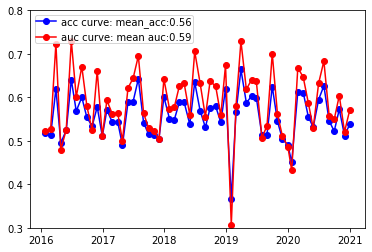

In [28]:
from datetime import datetime
from sklearn.metrics import roc_auc_score

#计算二分类模型样本外的ACC与AUC
def get_test_auc_acc():
    df = original_predict_score_xgb
    #只查看原有label为+1, -1的数据
    df = df[df['label'] != 0]
    df.loc[:, 'predict'] = df.loc[:, 'original_predict_score'].apply(lambda x : 1 if x > 0.5 else -1)

    acc_list = []
    auc_list = []
    for date, group in df.groupby('tdate'):
        df_correct = group[group['predict'] == group['label']]
        correct = len(df_correct) * 1.0 / len(group)
        auc =  roc_auc_score(np.array(group['label']), np.array(group['original_predict_score']))
        acc_list.append([date, correct])
        auc_list.append([date, auc])
        
    acc_list = sorted(acc_list, key=lambda x: x[0], reverse=False)
    mean_acc = sum([item[1] for item in acc_list]) / len(acc_list)
    
    auc_list = sorted(auc_list, key=lambda x: x[0], reverse=False)
    mean_auc = sum([item[1] for item in auc_list]) / len(auc_list)
    
    return acc_list, auc_list, round(mean_acc, 2), round(mean_auc, 2)

def plot_accuracy_curve():
    acc_list, auc_list, mean_acc, mean_auc = get_test_auc_acc()

    plt.plot([datetime.strptime(str(item[0]), '%Y-%m-%d') for item in acc_list], [item[1] for item in acc_list], '-bo')
    plt.plot([datetime.strptime(str(item[0]), '%Y-%m-%d') for item in auc_list], [item[1] for item in auc_list], '-ro')

    plt.legend([u"acc curve: mean_acc:%s"%mean_acc, u"auc curve: mean auc:%s"%mean_auc], loc='upper left', handlelength=2, handletextpad=0.5, borderpad=0.1)
    plt.ylim((0.3, 0.8))
    plt.show()

plot_accuracy_curve()

### Show the importance of feature

In [29]:
def get_feature_importance():
    df = pd.DataFrame(index=factors, columns=range(2016, 2021))
    for i, column in enumerate(range(2016, 2021)):
        feature_importance = boost_model_list[i].boost_model.get_score(importance_type='weight')
        df[column] = pd.Series(index=[list(factors)[int(key.replace('f', ''))] for key, value in feature_importance.items()], data =[value for key, value in feature_importance.items()])
        df[column] = df[column].fillna(0.0)
        df[column] = 1 + np.argsort(np.argsort(df[column]))
        
    df['all'] = df.mean(axis=1)
    
    return df.sort_values('all', ascending=False)
        
feature_importance_df = get_feature_importance()
feature_importance_df.iloc[np.r_[0:32]]

,2016,2017,2018,2019,2020,all
turn,30,32,32,32,32,31.6
dma,32,31,30,31,31,31.0
ARBR,31,29,31,29,30,30.0
ln_capital,29,30,29,30,29,29.4
S_FA_YOYOP,27,28,28,28,23,26.8
ln_price,26,25,26,22,28,25.4
BP,22,27,27,26,24,25.2
S_FA_ASSETSTURN,25,21,25,25,25,24.2
EP,17,24,21,27,26,23.0
std,28,26,24,19,18,23.0


<a id='h'></a>  
## Adaboost

In [31]:
datadn=dataset.groupby("ticker").apply(lambda x:x.fillna(method="ffill")).dropna()

In [32]:
datadn

,ticker,tdate,active return,EP,EPCUT,BP,SP,NCFP,OCFP,ln_capital,...,S_FA_YOYOCFPS,S_FA_YOYOP,S_FA_YOYEBT,S_FA_YOYNETPROFIT,S_FA_YOYNETPROFIT_DEDUCTED,S_FA_YOYOCF,S_FA_YOYROE,S_FA_YOY_OR,year,label
3109,000001.SZ,2010-03-31,-0.183190,0.718677,0.836862,-0.397797,-0.332407,2.526132,3.039867,2.307656,...,0.036328,-0.003551,0.382456,-0.106092,-0.079863,-0.913055,0.036328,-0.003551,2010,0
3110,000002.SZ,2010-03-31,-0.614868,0.437361,0.549906,-0.127688,-0.106413,0.117393,0.391716,2.643620,...,-0.057060,-0.003754,0.001382,-0.060805,-0.094321,-0.806039,-0.057060,-0.003754,2010,-1
3112,000006.SZ,2010-03-31,-0.785349,0.478118,0.327393,-0.166895,-0.249412,0.979265,0.186214,-0.065229,...,0.005880,-0.005699,0.006447,0.044772,-0.080096,-0.839057,0.005880,-0.005699,2010,-1
3113,000008.SZ,2010-03-31,0.194758,-0.321184,-0.228820,-1.159260,-0.506847,-0.128083,-0.234604,-1.833914,...,0.047216,-0.002912,-0.029850,0.197963,0.266333,-0.856386,0.047216,-0.002912,2010,0
3114,000009.SZ,2010-03-31,0.186255,-0.033658,-0.123575,-0.870776,-0.295377,0.688754,0.098970,0.662853,...,-0.010438,-0.003786,-0.003797,-0.039607,-0.043600,-0.683333,-0.010438,-0.003786,2010,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346847,603936.SH,2020-12-31,-0.971485,0.175714,0.228704,0.511852,-0.125028,-0.159823,-0.164579,-0.011868,...,-0.019573,-0.003758,-0.022213,-0.072909,-0.049450,0.369502,-0.019573,-0.003758,2020,0
346850,603939.SH,2020-12-31,0.671724,-0.102428,-0.002802,-1.053993,-0.290815,0.285857,-0.064470,1.916872,...,-0.004587,-0.003194,-0.012256,-0.072869,-0.059609,1.853448,-0.004587,-0.003194,2020,1
346859,603968.SH,2020-12-31,-0.777662,0.812550,0.806187,0.338719,0.097322,1.514335,0.626755,-0.616585,...,-0.002694,-0.004162,-0.025018,-0.016698,0.006892,1.602884,-0.002694,-0.004162,2020,0
346860,603969.SH,2020-12-31,0.324853,0.282098,0.396243,0.600596,0.150118,-0.022175,0.165650,-0.638762,...,15.021626,-0.005081,-0.024960,-0.014634,-0.004481,1.124940,15.021626,-0.005081,2020,1


In [33]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor

In [46]:
class BoostModel:
    def __init__(self):
        self.param_set = {'n_estimators': 600,'learning_rate':0.1}
            
    
    def fit(self, train_data, train_label):
        tree=DecisionTreeRegressor(max_depth=5)
        ada=AdaBoostRegressor(base_estimator=tree,
                        n_estimators=500,learning_rate=0.1 )
        boost_model = ada.fit(train_data,train_label)
        self.boost_model = boost_model
        
        return boost_model


    def predict(self, test_data):
        predict_score = self.boost_model.predict(test_data)
        
        return predict_score
        

In [47]:
def get_train_val_test_data(year, split_pct=0.9):
    back_year = max(2010, year-6)
    train_df = datadn[(datadn['year']>=back_year) & (datadn['year']<year)]
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    test_df = datadn[datadn['year']==year]
    
    return train_df, test_df

def format_feature_label(origin_df, is_filter=True):
    
    if is_filter:
        origin_df = origin_df[origin_df['label']!=0]
        #因子xgboost的label输入范围只能是[0, 1]，需要对原始label进行替换
        origin_df['label'] = origin_df['label'].replace(-1, 0)
        
    feature = np.array(origin_df[factors])
    label = np.array(origin_df['label'])

    return feature, label


def write_factor_to_csv(df, predict_score, year):
    #记录模型预测分数为因子值，输出
    df['original_predict_score'] = predict_score
    df = df.loc[:, ['ticker', 'tdate', 'label', 'original_predict_score']]
    is_header = True
    if year != 2016:
        is_header = False
    df[~(df['label']=='label')].to_csv('original_predict_score_adb.csv',mode='a+',header=is_header)

def pipeline():
    boost_model_list = []
    for year in range(2016, 2021):
        print('training model for %s' % year)
        train_df, test_df = get_train_val_test_data(year)
        boost_model = BoostModel()
        train_feature, train_label = format_feature_label(train_df)
        boost_model.fit(train_feature, train_label)
        
        test_feature, test_label = format_feature_label(test_df, False)
        predict_score = boost_model.predict(test_feature)
        
        write_factor_to_csv(test_df, predict_score, year)
        boost_model_list.append(boost_model)
    
    return boost_model_list



In [48]:
start_time = time.time()
boost_model_list = pipeline()
print("Done, Time Cost:%s seconds" % (time.time() - start_time))

training model for 2016


<ipython-input-47-1cf4b125fbf4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)
<ipython-input-47-1cf4b125fbf4>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-47-1cf4b125fbf4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

training model for 2017


<ipython-input-47-1cf4b125fbf4>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-47-1cf4b125fbf4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)


training model for 2018


<ipython-input-47-1cf4b125fbf4>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-47-1cf4b125fbf4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)


training model for 2019


<ipython-input-47-1cf4b125fbf4>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-47-1cf4b125fbf4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)


training model for 2020
Done, Time Cost:8.520401239395142 seconds


<ipython-input-47-1cf4b125fbf4>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score


In [49]:
original_predict_score_adb=pd.read_csv('original_predict_score_adb.csv',encoding='utf-8',low_memory=False)[['ticker','tdate','label','original_predict_score']]

In [50]:
original_predict_score_adb.dtypes

ticker                     object
tdate                      object
label                       int64
original_predict_score    float64
dtype: object

### Calculate the outsample ACC and AUC 

In [51]:
import matplotlib.pyplot as plt

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


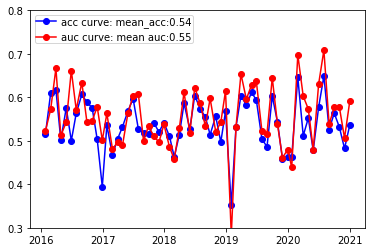

In [52]:
from datetime import datetime
from sklearn.metrics import roc_auc_score

#计算二分类模型样本外的ACC与AUC
def get_test_auc_acc():
    df = original_predict_score_adb
    #只查看原有label为+1, -1的数据
    df = df[df['label'] != 0]
    df.loc[:, 'predict'] = df.loc[:, 'original_predict_score'].apply(lambda x : 1 if x > 0.5 else -1)

    acc_list = []
    auc_list = []
    for date, group in df.groupby('tdate'):
        df_correct = group[group['predict'] == group['label']]
        correct = len(df_correct) * 1.0 / len(group)
        auc =  roc_auc_score(np.array(group['label']), np.array(group['original_predict_score']))
        acc_list.append([date, correct])
        auc_list.append([date, auc])
        
    acc_list = sorted(acc_list, key=lambda x: x[0], reverse=False)
    mean_acc = sum([item[1] for item in acc_list]) / len(acc_list)
    
    auc_list = sorted(auc_list, key=lambda x: x[0], reverse=False)
    mean_auc = sum([item[1] for item in auc_list]) / len(auc_list)
    
    return acc_list, auc_list, round(mean_acc, 2), round(mean_auc, 2)

def plot_accuracy_curve():
    acc_list, auc_list, mean_acc, mean_auc = get_test_auc_acc()

    plt.plot([datetime.strptime(str(item[0]), '%Y-%m-%d') for item in acc_list], [item[1] for item in acc_list], '-bo')
    plt.plot([datetime.strptime(str(item[0]), '%Y-%m-%d') for item in auc_list], [item[1] for item in auc_list], '-ro')

    plt.legend([u"acc curve: mean_acc:%s"%mean_acc, u"auc curve: mean auc:%s"%mean_auc], loc='upper left', handlelength=2, handletextpad=0.5, borderpad=0.1)
    plt.ylim((0.3, 0.8))
    plt.show()

plot_accuracy_curve()

### Show the importance of feature

In [57]:
def get_feature_importance():
    df = pd.DataFrame(index=factors, columns=range(2016, 2021))
    for i, column in enumerate(range(2016, 2021)):
        feature_importance = boost_model_list[i].boost_model.feature_importances_
        df[column] = pd.Series(index=list(factors), data=boost_model_list[i].boost_model.feature_importances_)
        df[column] = df[column].fillna(0.0)
        df[column] = 1 + np.argsort(np.argsort(df[column]))
        
    df['all'] = df.mean(axis=1)
    
    return df.sort_values('all', ascending=False)
        
feature_importance_df = get_feature_importance()
feature_importance_df.iloc[np.r_[0:32]]

D:\Anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:254: RuntimeWarning: invalid value encountered in true_divide
  return (sum(weight * clf.feature_importances_ for weight, clf


,2016,2017,2018,2019,2020,all
PSY,25,32,32,32,14,27.0
SP,17,30,30,30,23,26.0
S_FA_YOYOP,30,23,23,23,30,25.8
S_FA_YOYOCFPS,21,29,29,29,18,25.2
BP,15,27,27,27,27,24.6
std,26,24,24,24,24,24.4
S_FA_GROSSPROFITMARGIN,24,26,26,26,19,24.2
turn,31,16,16,16,32,22.2
S_FA_ROE,28,20,20,20,22,22.0
S_FA_YOYNETPROFIT,8,31,31,31,8,21.8


<a id='i'></a>
## GBDT

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import accuracy_score

In [45]:
class BoostModel:
    def __init__(self):
        self.param_set = {'n_estimators': 600,'learning_rate':0.1}
            
    
    def fit(self, train_data, train_label):
        tree=DecisionTreeRegressor(max_depth=5)
        gbd=GradientBoostingRegressor(base_estimator=tree,
                        n_estimators=500,learning_rate=0.1 )
        boost_model = gbd.fit(train_data,train_label)
        self.boost_model = boost_model
        
        return boost_model


    def predict(self, test_data):
        predict_score = self.boost_model.predict(test_data)
        
        return predict_score
        

In [62]:
def get_train_val_test_data(year, split_pct=0.9):
    back_year = max(2010, year-6)
    train_df = datadn[(datadn['year']>=back_year) & (datadn['year']<year)]
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    test_df = datadn[datadn['year']==year]
    
    return train_df, test_df

def format_feature_label(origin_df, is_filter=True):
    
    if is_filter:
        origin_df = origin_df[origin_df['label']!=0]
        #因子xgboost的label输入范围只能是[0, 1]，需要对原始label进行替换
        origin_df['label'] = origin_df['label'].replace(-1, 0)
        
    feature = np.array(origin_df[factors])
    label = np.array(origin_df['label'])

    return feature, label


def write_factor_to_csv(df, predict_score, year):
    #记录模型预测分数为因子值，输出
    df['original_predict_score'] = predict_score
    df = df.loc[:, ['ticker', 'tdate', 'label', 'original_predict_score']]
    is_header = True
    if year != 2016:
        is_header = False
    df[~(df['label']=='label')].to_csv('original_predict_score_gbdt.csv',mode='a+',header=is_header)

def pipeline():
    boost_model_list = []
    for year in range(2016, 2021):
        print('training model for %s' % year)
        train_df, test_df = get_train_val_test_data(year)
        boost_model = BoostModel()
        train_feature, train_label = format_feature_label(train_df)
        boost_model.fit(train_feature, train_label)
        
        test_feature, test_label = format_feature_label(test_df, False)
        predict_score = boost_model.predict(test_feature)
        
        write_factor_to_csv(test_df, predict_score, year)
        boost_model_list.append(boost_model)
    
    return boost_model_list



In [63]:
start_time = time.time()
boost_model_list = pipeline()
print("Done, Time Cost:%s seconds" % (time.time() - start_time))

training model for 2016


<ipython-input-62-260765b568d7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)
<ipython-input-62-260765b568d7>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-62-260765b568d7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

training model for 2017


<ipython-input-62-260765b568d7>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-62-260765b568d7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)


training model for 2018


<ipython-input-62-260765b568d7>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-62-260765b568d7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)


training model for 2019


<ipython-input-62-260765b568d7>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-62-260765b568d7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)


training model for 2020
Done, Time Cost:10.828487396240234 seconds


<ipython-input-62-260765b568d7>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score


In [67]:
original_predict_score_gbdt=pd.read_csv('original_predict_score_gbdt.csv',encoding='utf-8',low_memory=False)[['ticker','tdate','label','original_predict_score']]

In [68]:
original_predict_score_gbdt.dtypes

ticker                     object
tdate                      object
label                       int64
original_predict_score    float64
dtype: object

### Calculate the outsample ACC and AUC 

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


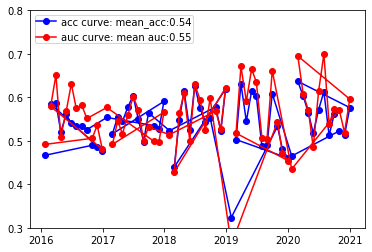

In [71]:
from datetime import datetime
from sklearn.metrics import roc_auc_score

#计算二分类模型样本外的ACC与AUC
def get_test_auc_acc():
    df = original_predict_score_gbdt
    #只查看原有label为+1, -1的数据
    df = df[df['label'] != 0]
    df.loc[:, 'predict'] = df.loc[:, 'original_predict_score'].apply(lambda x : 1 if x > 0.5 else -1)

    acc_list = []
    auc_list = []
    for date, group in df.groupby('tdate'):
        df_correct = group[group['predict'] == group['label']]
        correct = len(df_correct) * 1.0 / len(group)
        auc =  roc_auc_score(np.array(group['label']), np.array(group['original_predict_score']))
        acc_list.append([date, correct])
        auc_list.append([date, auc])
        
    acc_list = sorted(acc_list, key=lambda x: x[0], reverse=False)
    mean_acc = sum([item[1] for item in acc_list]) / len(acc_list)
    
    auc_list = sorted(auc_list, key=lambda x: x[0], reverse=False)
    mean_auc = sum([item[1] for item in auc_list]) / len(auc_list)
    
    return acc_list, auc_list, round(mean_acc, 2), round(mean_auc, 2)

def plot_accuracy_curve():
    acc_list, auc_list, mean_acc, mean_auc = get_test_auc_acc()

    plt.plot([datetime.strptime(str(item[0]), '%Y/%m/%d') for item in acc_list], [item[1] for item in acc_list], '-bo')
    plt.plot([datetime.strptime(str(item[0]), '%Y/%m/%d') for item in auc_list], [item[1] for item in auc_list], '-ro')

    plt.legend([u"acc curve: mean_acc:%s"%mean_acc, u"auc curve: mean auc:%s"%mean_auc], loc='upper left', handlelength=2, handletextpad=0.5, borderpad=0.1)
    plt.ylim((0.3, 0.8))
    plt.show()

plot_accuracy_curve()

### Show the importance of feature

In [72]:
def get_feature_importance():
    df = pd.DataFrame(index=factors, columns=range(2016, 2021))
    for i, column in enumerate(range(2016, 2021)):
        feature_importance = boost_model_list[i].boost_model.feature_importances_
        df[column] = pd.Series(index=list(factors), data=boost_model_list[i].boost_model.feature_importances_)
        df[column] = df[column].fillna(0.0)
        df[column] = 1 + np.argsort(np.argsort(df[column]))
        
    df['all'] = df.mean(axis=1)
    
    return df.sort_values('all', ascending=False)
        
feature_importance_df = get_feature_importance()
feature_importance_df.iloc[np.r_[0:32]]

D:\Anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:254: RuntimeWarning: invalid value encountered in true_divide
  return (sum(weight * clf.feature_importances_ for weight, clf


,2016,2017,2018,2019,2020,all
turn,31,30,32,16,32,28.2
ln_capital,32,32,31,4,31,26.0
S_FA_YOYOP,28,27,21,23,30,25.8
S_FA_YOY_OR,30,29,30,8,28,25.0
ARBR,18,23,29,22,26,23.6
dma,29,31,23,5,27,23.0
BP,4,28,27,27,29,23.0
std,22,26,25,24,18,23.0
PSY,21,22,26,32,13,22.8
ln_price,24,24,28,19,17,22.4


<a id='j'></a>
## Boosting with parameter optimization

<a id='k'></a>
## XGBoost 

In [73]:
from sklearn.model_selection import GridSearchCV #网格搜索
from sklearn.model_selection import train_test_split,KFold #数据集划分，交叉验证
import xgboost as xgb  

In [74]:
class BoostModel:
    def __init__(self, num_round=2000, early_stopping_rounds=50):
        self.param_set = {'max_depth': [3,4,5,6,7,8,9,10], 'subsample': [0.7,0.75,0.8,0.85,0.9,0.95,1]}
        self.param_dict = { 'eta': 0.1, 'silent': 1, 'alpha': 0.5, 'lambda': 0.5, 'eval_metric':'auc','objective':'binary:logistic','n_jobs': -1} 
        self.num_round = num_round
        self.early_stopping_rounds = early_stopping_rounds

    def grid_best_parameters(self,train_data,train_label):
        kfold=KFold(n_splits=10,shuffle=True)
        boost_model = xgb.XGBRegressor(**self.param_dict)    
        grid_search= GridSearchCV(boost_model,self.param_set,scoring ='roc_auc',n_jobs = -1,cv = kfold)
        grid_parameters=grid_search.fit(train_data, train_label).best_params_
        best_parameters=grid_parameters.update(self.param_dict)
        
        return grid_parameters
        
    
    def fit(self, best_parameters, train_data, train_label,  val_data, val_label):
        dtrain = xgb.DMatrix(train_data, label=train_label)
        deval = xgb.DMatrix(val_data, label=val_label)
        boost_model = xgb.train(best_parameters, dtrain, num_boost_round=self.num_round, evals=[(dtrain,'train'), (deval, 'eval')], early_stopping_rounds=self.early_stopping_rounds, verbose_eval=False)
        print('get best eval auc : %s, in step %s'%(boost_model.best_score, boost_model.best_iteration))
        self.boost_model = boost_model
        
        return boost_model


    def predict(self, test_data):
        dtest = xgb.DMatrix(test_data)
        predict_score = self.boost_model.predict(dtest, ntree_limit=self.boost_model.best_ntree_limit)
        
        return predict_score
        

In [75]:
def get_train_val_test_data(year, split_pct=0.9):
    back_year = max(2010, year-6)
    train_val_df = dataset[(dataset['year']>=back_year) & (dataset['year']<year)]
    train_val_df = train_val_df.sample(frac=1).reset_index(drop=True)
    
    #拆分训练集、验证集
    train_df = train_val_df.iloc[0:int(len(train_val_df) * split_pct)]
    val_df = train_val_df.iloc[int(len(train_val_df) * split_pct):]
    
    test_df = dataset[dataset['year']==year]
    
    return train_df, val_df, test_df

def format_feature_label(origin_df, is_filter=True):
    
    if is_filter:
        origin_df = origin_df[origin_df['label']!=0]
        #因子xgboost的label输入范围只能是[0, 1]，需要对原始label进行替换
        origin_df['label'] = origin_df['label'].replace(-1, 0)
        
    feature = np.array(origin_df[factors])
    label = np.array(origin_df['label'])

    return feature, label

def write_factor_to_csv(df, predict_score, year):
    #记录模型预测分数为因子值，输出
    df['original_predict_score'] = predict_score
    df = df.loc[:, ['ticker', 'tdate', 'label', 'original_predict_score']]
    is_header = True
    if year != 2016:
        is_header = False
    df[~(df['label']=='label')].to_csv('original_predict_score.csv',mode='a+',header=is_header)

def pipeline():
    boost_model_list_adb = []
    for year in range(2016, 2021):
        print('training model for %s' % year)
        train_df, val_df, test_df = get_train_val_test_data(year)
        boost_model = BoostModel()
        train_feature, train_label = format_feature_label(train_df)
        val_feature, val_label = format_feature_label(val_df)
        best_parameters=boost_model.grid_best_parameters(train_feature,train_label)
        boost_model.fit(best_parameters,train_feature, train_label, val_feature, val_label)
        
        test_feature, test_label = format_feature_label(test_df, False)
        predict_score = boost_model.predict(test_feature)
        
        write_factor_to_csv(test_df, predict_score, year)
        boost_model_list.append(boost_model)
    
    return boost_model_list



In [76]:
start_time = time.time()
boost_model_list = pipeline()
print("Done, Time Cost:%s seconds" % (time.time() - start_time))

training model for 2016


<ipython-input-75-6799dc2d7754>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)
<ipython-input-75-6799dc2d7754>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)


[03:42:29] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:42:39] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


get best eval auc : 0.643709, in step 76
training model for 2017


<ipython-input-75-6799dc2d7754>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-75-6799dc2d7754>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)
<ipython-input-75-6799dc2d7754>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

[04:36:16] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:36:25] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


get best eval auc : 0.634659, in step 73
training model for 2018


<ipython-input-75-6799dc2d7754>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-75-6799dc2d7754>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)
<ipython-input-75-6799dc2d7754>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

[05:30:43] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:30:51] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


get best eval auc : 0.625238, in step 53
training model for 2019


<ipython-input-75-6799dc2d7754>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-75-6799dc2d7754>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)
<ipython-input-75-6799dc2d7754>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

[06:28:14] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[06:28:24] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


get best eval auc : 0.63056, in step 72
training model for 2020


<ipython-input-75-6799dc2d7754>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-75-6799dc2d7754>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)
<ipython-input-75-6799dc2d7754>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

[07:29:40] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:29:49] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


get best eval auc : 0.622565, in step 194
Done, Time Cost:17594.643392562866 seconds


<ipython-input-75-6799dc2d7754>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score


In [77]:
original_predict_score=pd.read_csv('original_predict_score.csv',encoding='utf-8',low_memory=False)[['ticker','tdate','label','original_predict_score']]

In [78]:
original_predict_score.dtypes

ticker                     object
tdate                      object
label                       int64
original_predict_score    float64
dtype: object

### Calculate the outsample ACC and AUC 

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


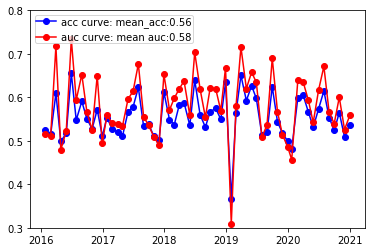

In [79]:
from datetime import datetime
from sklearn.metrics import roc_auc_score

#计算二分类模型样本外的ACC与AUC
def get_test_auc_acc():
    df = original_predict_score
    #只查看原有label为+1, -1的数据
    df = df[df['label'] != 0]
    df.loc[:, 'predict'] = df.loc[:, 'original_predict_score'].apply(lambda x : 1 if x > 0.5 else -1)

    acc_list = []
    auc_list = []
    for date, group in df.groupby('tdate'):
        df_correct = group[group['predict'] == group['label']]
        correct = len(df_correct) * 1.0 / len(group)
        auc =  roc_auc_score(np.array(group['label']), np.array(group['original_predict_score']))
        acc_list.append([date, correct])
        auc_list.append([date, auc])
        
    acc_list = sorted(acc_list, key=lambda x: x[0], reverse=False)
    mean_acc = sum([item[1] for item in acc_list]) / len(acc_list)
    
    auc_list = sorted(auc_list, key=lambda x: x[0], reverse=False)
    mean_auc = sum([item[1] for item in auc_list]) / len(auc_list)
    
    return acc_list, auc_list, round(mean_acc, 2), round(mean_auc, 2)

def plot_accuracy_curve():
    acc_list, auc_list, mean_acc, mean_auc = get_test_auc_acc()

    plt.plot([datetime.strptime(str(item[0]), '%Y-%m-%d') for item in acc_list], [item[1] for item in acc_list], '-bo')
    plt.plot([datetime.strptime(str(item[0]), '%Y-%m-%d') for item in auc_list], [item[1] for item in auc_list], '-ro')

    plt.legend([u"acc curve: mean_acc:%s"%mean_acc, u"auc curve: mean auc:%s"%mean_auc], loc='upper left', handlelength=2, handletextpad=0.5, borderpad=0.1)
    plt.ylim((0.3, 0.8))
    plt.show()

plot_accuracy_curve()

### Show the importance of feature

In [81]:
def get_feature_importance():
    df = pd.DataFrame(index=factors, columns=range(2016, 2021))
    for i, column in enumerate(range(2016, 2021)):
        feature_importance = boost_model_list[i].boost_model.get_score(importance_type='weight')
        df[column] = pd.Series(index=[list(factors)[int(key.replace('f', ''))] for key, value in feature_importance.items()], data =[value for key, value in feature_importance.items()])
        df[column] = df[column].fillna(0.0)
        df[column] = 1 + np.argsort(np.argsort(df[column]))
        
    df['all'] = df.mean(axis=1)
    
    return df.sort_values('all', ascending=False)
        
feature_importance_df = get_feature_importance()
feature_importance_df.iloc[np.r_[0:32]]

,2016,2017,2018,2019,2020,all
turn,32,32,32,32,32,32.0
ARBR,31,31,31,31,31,31.0
dma,30,30,30,30,30,30.0
ln_capital,29,29,29,29,29,29.0
ln_price,28,27,26,27,28,27.2
BP,26,26,27,28,27,26.8
std,27,28,25,23,25,25.6
S_FA_YOYOP,24,25,28,26,21,24.8
S_FA_ASSETSTURN,23,22,24,24,26,23.8
NCFP,25,23,21,25,20,22.8


<a id='l'></a>
## Adaboost

In [82]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split,KFold 

In [129]:
class BoostModel:
    def __init__(self):
        self.param_set = {'n_estimators': [100,500,1000],'learning_rate':[0.1,0.3,0.5] }

    def grid_best_parameters(self,train_data,train_label):
        kfold=KFold(n_splits=10,shuffle=True)
        boost_model = AdaBoostRegressor()    
        grid_search= GridSearchCV(boost_model,self.param_set,scoring ='roc_auc',n_jobs = -1,cv = kfold)
        grid_parameters=grid_search.fit(train_data, train_label).best_params_
        
        
        return grid_parameters
        
    
    def fit(self, best_parameters, train_data, train_label):
        ada=AdaBoostRegressor()
        ada=ada.set_params(**best_parameters)
        boost_model = ada.fit(train_data,train_label)
        self.boost_model = boost_model
        
        return boost_model


    def predict(self, test_data):
        predict_score = self.boost_model.predict(test_data)
        
        return predict_score
        

In [130]:
def get_train_val_test_data(year, split_pct=0.9):
    back_year = max(2010, year-6)
    train_df = datadn[(datadn['year']>=back_year) & (datadn['year']<year)]
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    test_df = datadn[datadn['year']==year]
    
    return train_df, test_df

def format_feature_label(origin_df, is_filter=True):
    
    if is_filter:
        origin_df = origin_df[origin_df['label']!=0]
        #因子xgboost的label输入范围只能是[0, 1]，需要对原始label进行替换
        origin_df['label'] = origin_df['label'].replace(-1, 0)
        
    feature = np.array(origin_df[factors])
    label = np.array(origin_df['label'])

    return feature, label


def write_factor_to_csv(df, predict_score, year):
    #记录模型预测分数为因子值，输出
    df['original_predict_score'] = predict_score
    df = df.loc[:, ['ticker', 'tdate', 'label', 'original_predict_score']]
    is_header = True
    if year != 2016:
        is_header = False
    df[~(df['label']=='label')].to_csv('original_predict_score_adb_op.csv',mode='a+',header=is_header)

def pipeline():
    boost_model_list_adb = []
    for year in range(2016, 2021):
        print('training model for %s' % year)
        train_df, test_df = get_train_val_test_data(year)
        boost_model = BoostModel()
        train_feature, train_label = format_feature_label(train_df)
        best_parameters=boost_model.grid_best_parameters(train_feature,train_label)
        boost_model.fit(best_parameters,train_feature, train_label)
        
        test_feature, test_label = format_feature_label(test_df, False)
        predict_score = boost_model.predict(test_feature)
        
        write_factor_to_csv(test_df, predict_score, year)
        boost_model_list_adb.append(boost_model)
    
    return boost_model_list_adb



In [131]:
start_time = time.time()
boost_model_list_adb = pipeline()
print("Done, Time Cost:%s seconds" % (time.time() - start_time))

training model for 2016


<ipython-input-130-05ec2704d30b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)
<ipython-input-130-05ec2704d30b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-130-05ec2704d30b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

training model for 2017


<ipython-input-130-05ec2704d30b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-130-05ec2704d30b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)


training model for 2018


<ipython-input-130-05ec2704d30b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-130-05ec2704d30b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)


training model for 2019


<ipython-input-130-05ec2704d30b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-130-05ec2704d30b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)


training model for 2020
Done, Time Cost:32.908663749694824 seconds


<ipython-input-130-05ec2704d30b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score


In [132]:
original_predict_score_adb_op=pd.read_csv('original_predict_score_adb_op.csv',encoding='utf-8',low_memory=False)[['ticker','tdate','label','original_predict_score']]

In [133]:
original_predict_score_adb_op.dtypes

ticker                     object
tdate                      object
label                       int64
original_predict_score    float64
dtype: object

### Calculate the outsample ACC and AUC 

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


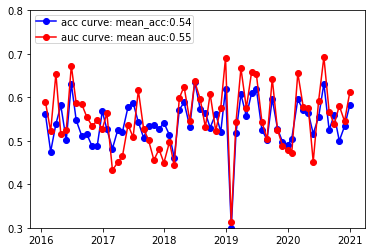

In [134]:
from datetime import datetime
from sklearn.metrics import roc_auc_score

#计算二分类模型样本外的ACC与AUC
def get_test_auc_acc():
    df = original_predict_score_adb_op
    #只查看原有label为+1, -1的数据
    df = df[df['label'] != 0]
    df.loc[:, 'predict'] = df.loc[:, 'original_predict_score'].apply(lambda x : 1 if x > 0.5 else -1)

    acc_list = []
    auc_list = []
    for date, group in df.groupby('tdate'):
        df_correct = group[group['predict'] == group['label']]
        correct = len(df_correct) * 1.0 / len(group)
        auc =  roc_auc_score(np.array(group['label']), np.array(group['original_predict_score']))
        acc_list.append([date, correct])
        auc_list.append([date, auc])
        
    acc_list = sorted(acc_list, key=lambda x: x[0], reverse=False)
    mean_acc = sum([item[1] for item in acc_list]) / len(acc_list)
    
    auc_list = sorted(auc_list, key=lambda x: x[0], reverse=False)
    mean_auc = sum([item[1] for item in auc_list]) / len(auc_list)
    
    return acc_list, auc_list, round(mean_acc, 2), round(mean_auc, 2)

def plot_accuracy_curve():
    acc_list, auc_list, mean_acc, mean_auc = get_test_auc_acc()

    plt.plot([datetime.strptime(str(item[0]), '%Y-%m-%d') for item in acc_list], [item[1] for item in acc_list], '-bo')
    plt.plot([datetime.strptime(str(item[0]), '%Y-%m-%d') for item in auc_list], [item[1] for item in auc_list], '-ro')

    plt.legend([u"acc curve: mean_acc:%s"%mean_acc, u"auc curve: mean auc:%s"%mean_auc], loc='upper left', handlelength=2, handletextpad=0.5, borderpad=0.1)
    plt.ylim((0.3, 0.8))
    plt.show()

plot_accuracy_curve()

<a id='m'></a>
## GBDT

In [136]:
class BoostModel:
    def __init__(self):
        self.param_set = {'n_estimators': [100,500,1000],'learning_rate':[0.1,0.3,0.5] }

    def grid_best_parameters(self,train_data,train_label):
        kfold=KFold(n_splits=10,shuffle=True)
        boost_model = GradientBoostingRegressor()
        grid_search= GridSearchCV(boost_model,self.param_set,scoring ='roc_auc',n_jobs = -1,cv = kfold)
        grid_parameters=grid_search.fit(train_data, train_label).best_params_
        
        
        return grid_parameters
        
    
    def fit(self, best_parameters, train_data, train_label):
        gbdt=GradientBoostingRegressor()
        gbdt=gbdt.set_params(**best_parameters)
        boost_model = gbdt.fit(train_data,train_label)
        self.boost_model = boost_model
        
        return boost_model


    def predict(self, test_data):
        predict_score = self.boost_model.predict(test_data)
        
        return predict_score
        

In [137]:
def get_train_val_test_data(year, split_pct=0.9):
    back_year = max(2010, year-6)
    train_df = datadn[(datadn['year']>=back_year) & (datadn['year']<year)]
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    test_df = datadn[datadn['year']==year]
    
    return train_df, test_df

def format_feature_label(origin_df, is_filter=True):
    
    if is_filter:
        origin_df = origin_df[origin_df['label']!=0]
        #因子xgboost的label输入范围只能是[0, 1]，需要对原始label进行替换
        origin_df['label'] = origin_df['label'].replace(-1, 0)
        
    feature = np.array(origin_df[factors])
    label = np.array(origin_df['label'])

    return feature, label


def write_factor_to_csv(df, predict_score, year):
    #记录模型预测分数为因子值，输出
    df['original_predict_score'] = predict_score
    df = df.loc[:, ['ticker', 'tdate', 'label', 'original_predict_score']]
    is_header = True
    if year != 2016:
        is_header = False
    df[~(df['label']=='label')].to_csv('original_predict_score_gbdt_op.csv',mode='a+',header=is_header)

def pipeline():
    boost_model_list_gbdt = []
    for year in range(2016, 2021):
        print('training model for %s' % year)
        train_df, test_df = get_train_val_test_data(year)
        boost_model = BoostModel()
        train_feature, train_label = format_feature_label(train_df)
        best_parameters=boost_model.grid_best_parameters(train_feature,train_label)
        boost_model.fit(best_parameters,train_feature, train_label)
        
        test_feature, test_label = format_feature_label(test_df, False)
        predict_score = boost_model.predict(test_feature)
        
        write_factor_to_csv(test_df, predict_score, year)
        boost_model_list_gbdt.append(boost_model)
    
    return boost_model_list_gbdt



In [138]:
start_time = time.time()
boost_model_list_gbdt = pipeline()
print("Done, Time Cost:%s seconds" % (time.time() - start_time))

training model for 2016


<ipython-input-137-a8822892ccd2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)
<ipython-input-137-a8822892ccd2>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-137-a8822892ccd2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

training model for 2017


<ipython-input-137-a8822892ccd2>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-137-a8822892ccd2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)


training model for 2018


<ipython-input-137-a8822892ccd2>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-137-a8822892ccd2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)


training model for 2019


<ipython-input-137-a8822892ccd2>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score
<ipython-input-137-a8822892ccd2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_df['label'] = origin_df['label'].replace(-1, 0)


training model for 2020
Done, Time Cost:15973.548040151596 seconds


<ipython-input-137-a8822892ccd2>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_predict_score'] = predict_score


In [139]:
original_predict_score_gbdt_op=pd.read_csv('original_predict_score_gbdt_op.csv',encoding='utf-8',low_memory=False)[['ticker','tdate','label','original_predict_score']]

In [140]:
original_predict_score_gbdt_op.dtypes

ticker                     object
tdate                      object
label                       int64
original_predict_score    float64
dtype: object

### Calculate the outsample ACC and AUC 

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


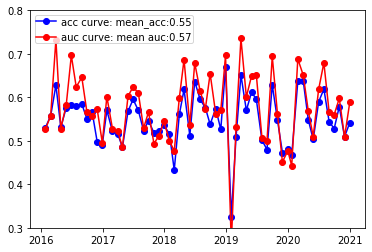

In [141]:
from datetime import datetime
from sklearn.metrics import roc_auc_score

#计算二分类模型样本外的ACC与AUC
def get_test_auc_acc():
    df = original_predict_score_gbdt_op
    #只查看原有label为+1, -1的数据
    df = df[df['label'] != 0]
    df.loc[:, 'predict'] = df.loc[:, 'original_predict_score'].apply(lambda x : 1 if x > 0.5 else -1)

    acc_list = []
    auc_list = []
    for date, group in df.groupby('tdate'):
        df_correct = group[group['predict'] == group['label']]
        correct = len(df_correct) * 1.0 / len(group)
        auc =  roc_auc_score(np.array(group['label']), np.array(group['original_predict_score']))
        acc_list.append([date, correct])
        auc_list.append([date, auc])
        
    acc_list = sorted(acc_list, key=lambda x: x[0], reverse=False)
    mean_acc = sum([item[1] for item in acc_list]) / len(acc_list)
    
    auc_list = sorted(auc_list, key=lambda x: x[0], reverse=False)
    mean_auc = sum([item[1] for item in auc_list]) / len(auc_list)
    
    return acc_list, auc_list, round(mean_acc, 2), round(mean_auc, 2)

def plot_accuracy_curve():
    acc_list, auc_list, mean_acc, mean_auc = get_test_auc_acc()

    plt.plot([datetime.strptime(str(item[0]), '%Y-%m-%d') for item in acc_list], [item[1] for item in acc_list], '-bo')
    plt.plot([datetime.strptime(str(item[0]), '%Y-%m-%d') for item in auc_list], [item[1] for item in auc_list], '-ro')

    plt.legend([u"acc curve: mean_acc:%s"%mean_acc, u"auc curve: mean auc:%s"%mean_auc], loc='upper left', handlelength=2, handletextpad=0.5, borderpad=0.1)
    plt.ylim((0.3, 0.8))
    plt.show()

plot_accuracy_curve()

### Show the importance of feature

In [142]:
def get_feature_importance():
    df = pd.DataFrame(index=factors, columns=range(2016, 2021))
    for i, column in enumerate(range(2016, 2021)):
        feature_importance = boost_model_list_gbdt[i].boost_model.feature_importances_
        df[column] = pd.Series(index=list(factors), data=boost_model_list_gbdt[i].boost_model.feature_importances_)
        df[column] = df[column].fillna(0.0)
        df[column] = 1 + np.argsort(np.argsort(df[column]))
        
    df['all'] = df.mean(axis=1)
    
    return df.sort_values('all', ascending=False)
        
feature_importance_df = get_feature_importance()
feature_importance_df.iloc[np.r_[0:32]]

,2016,2017,2018,2019,2020,all
ln_capital,32,32,31,31,31,31.4
turn,30,31,32,32,32,31.4
dma,31,30,30,30,30,30.2
std,29,29,28,29,26,28.2
S_FA_YOY_OR,27,27,29,27,28,27.6
ARBR,28,25,24,28,29,26.8
BP,22,22,25,26,27,24.4
S_FA_YOYOP,26,26,27,21,22,24.4
PSY,25,28,26,20,20,23.8
ln_price,23,24,23,23,24,23.4


<a id='n'></a>
## Backtest  
We choose the most imortant 3 features and the least important 3 features given by XGBoosting with paratemter optimized to do single factor backtesting.Besides, we use the predicted score as a 'factor' to do sigle factor backtesting.  
To do the backtest,we need to adjust the fatcor data to pivot form and adjust the table to suit the backtest framework.Here we omit the code to adjust the data.After we adjust the dataframe, we need to save the factor data and code like the following to do backtest.  
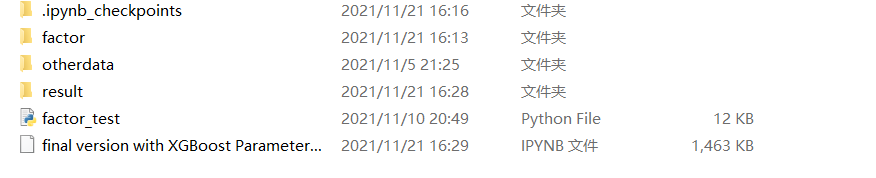

In [1]:
Path_factor='./'

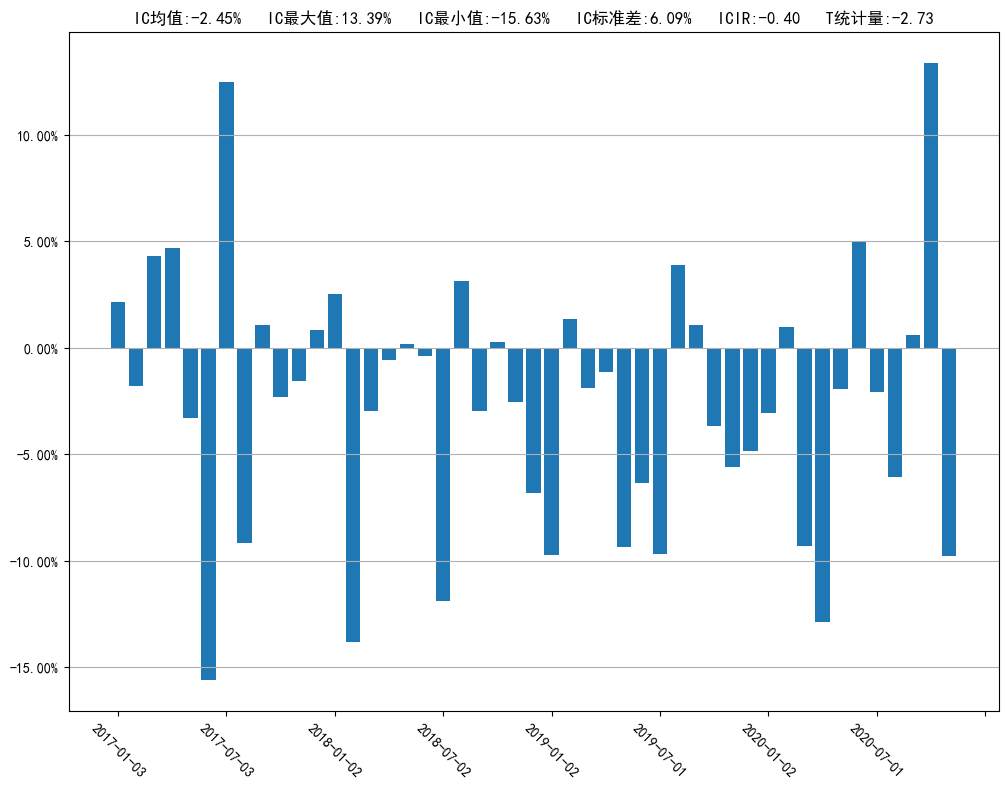

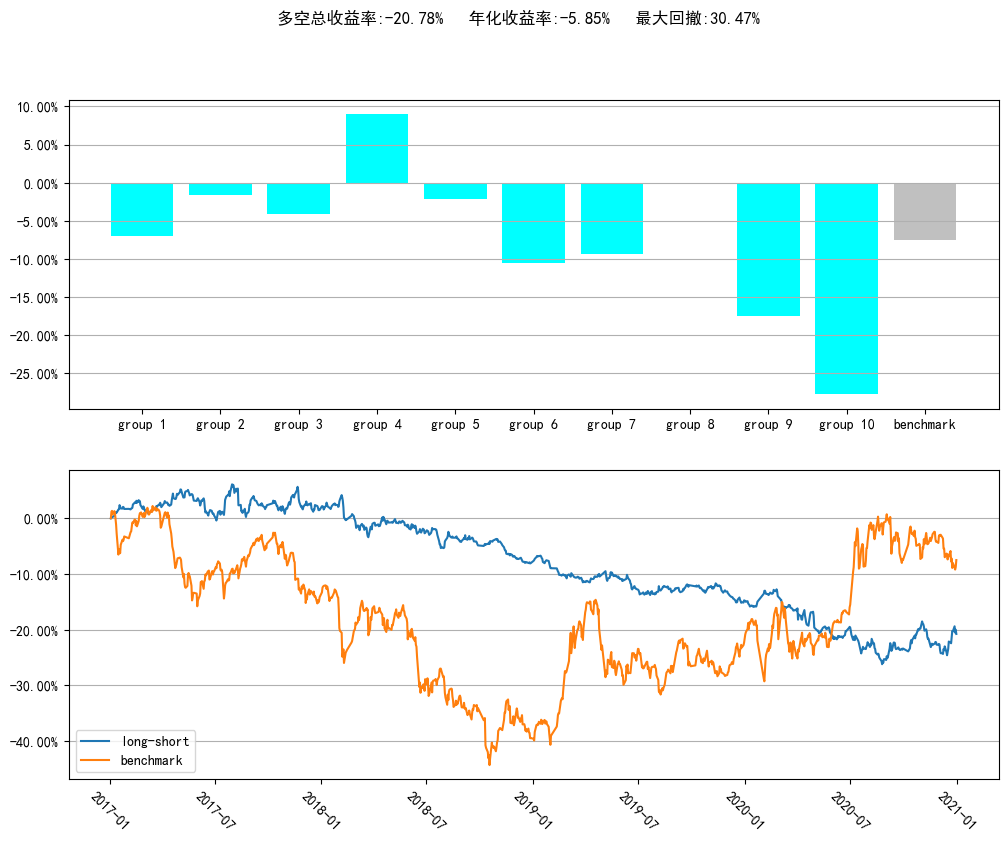

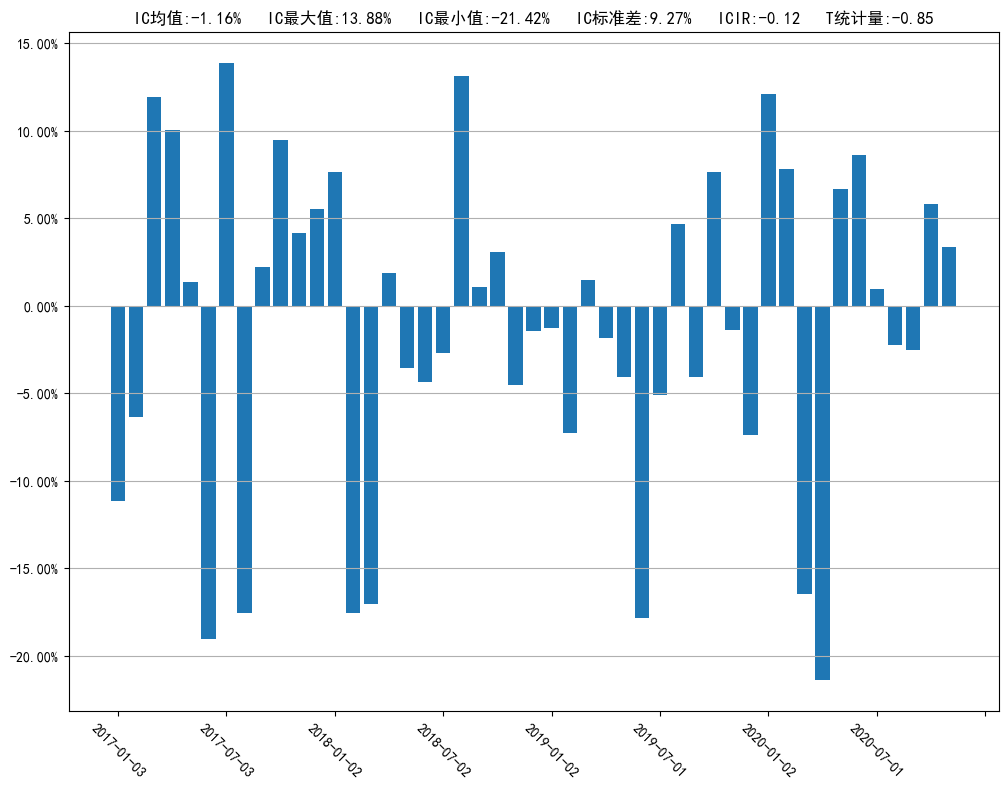

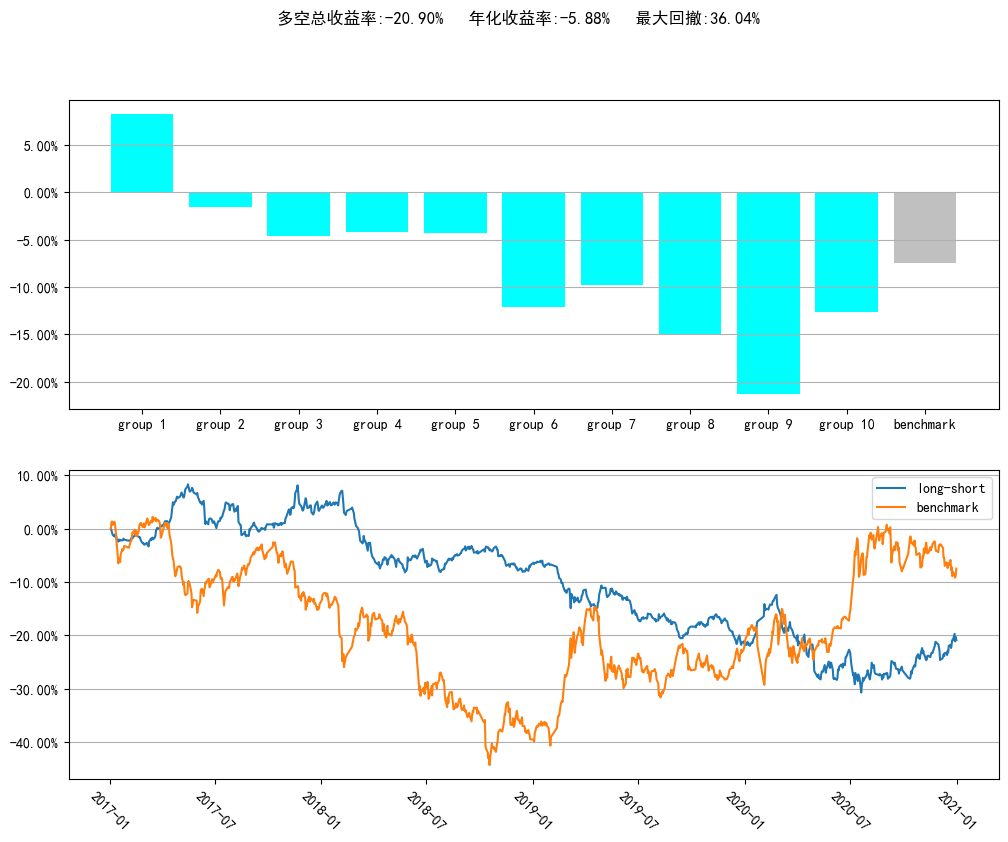

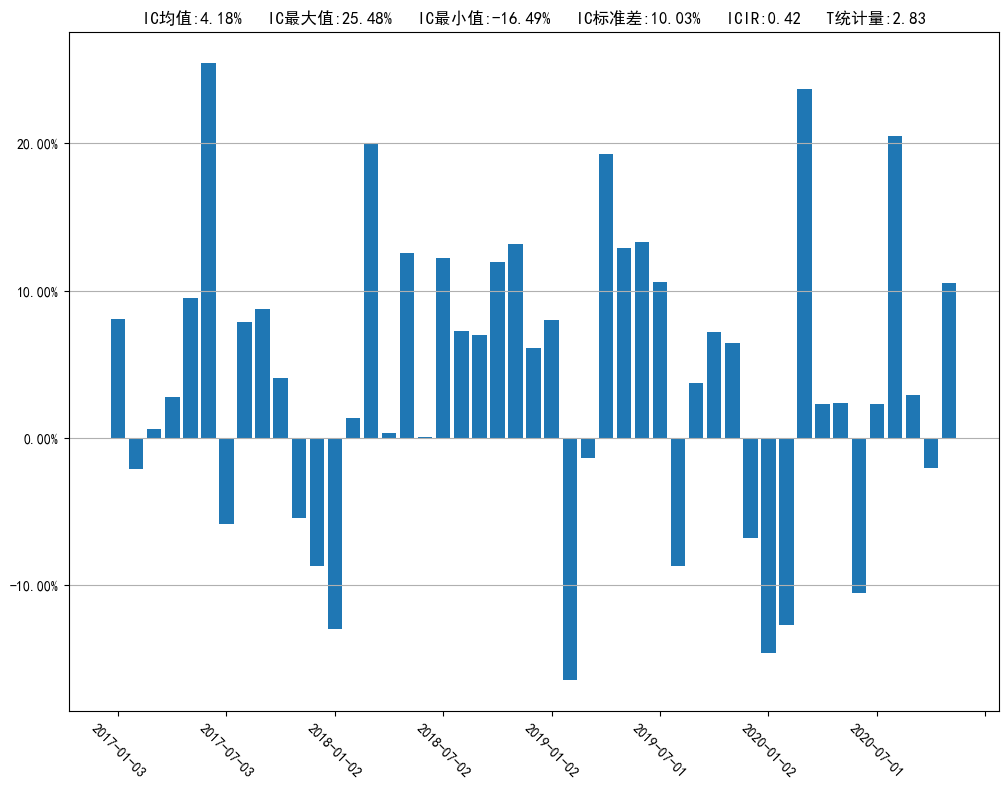

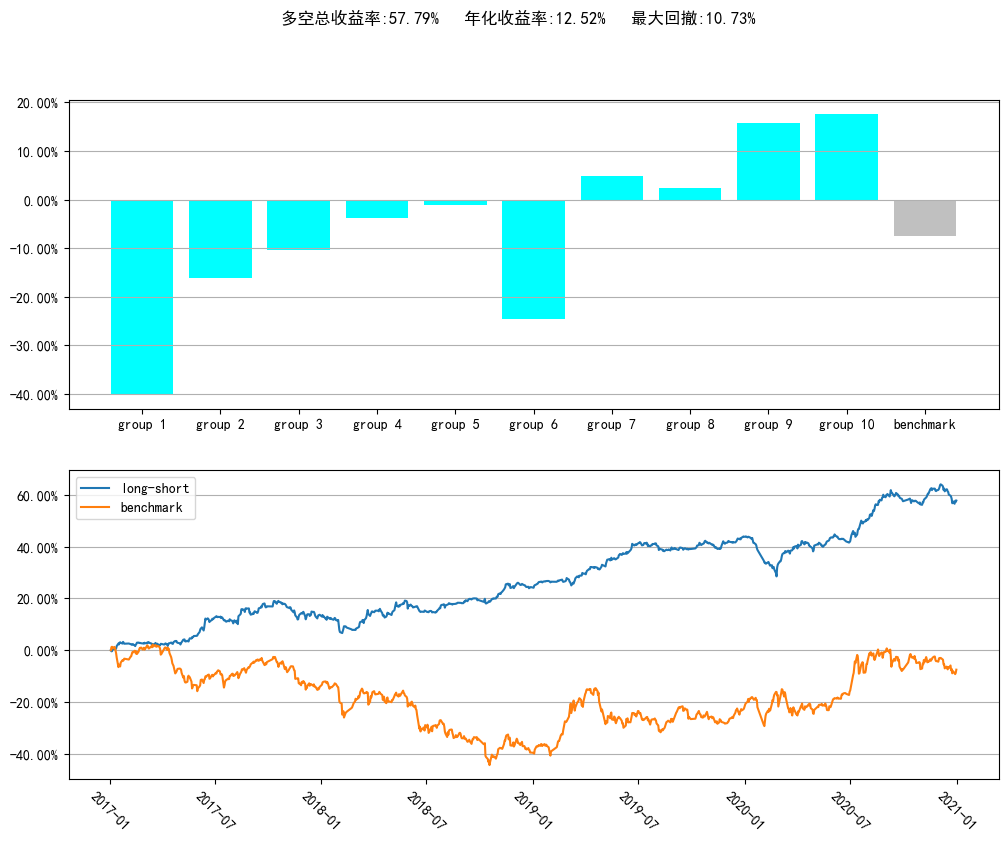

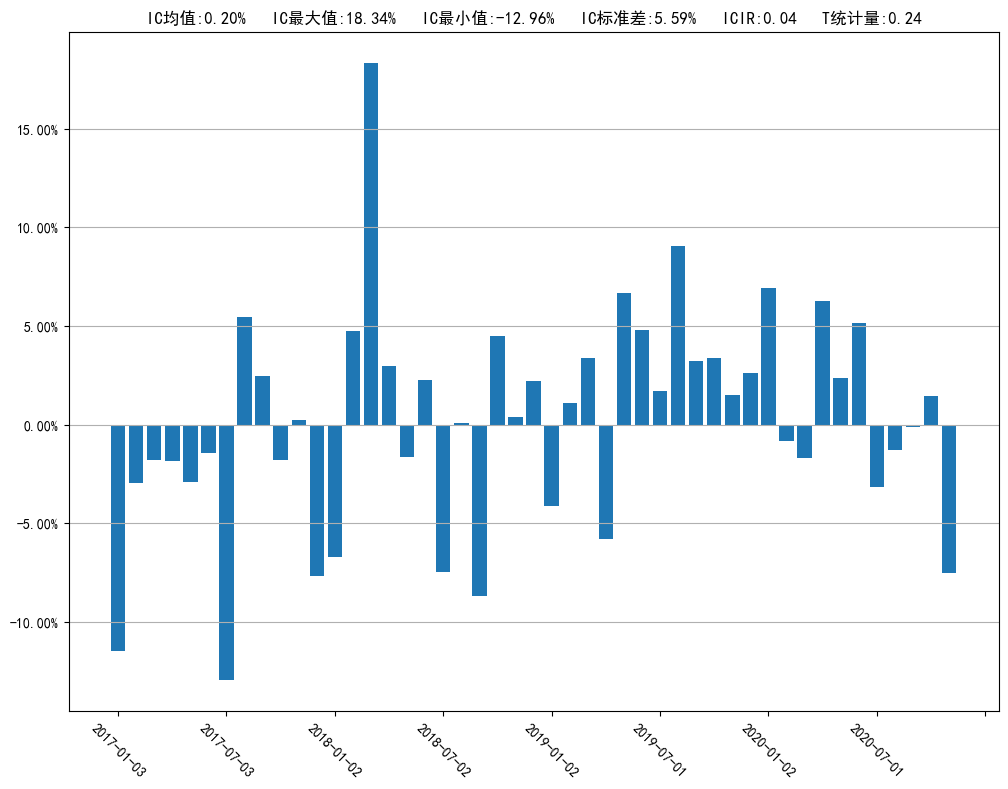

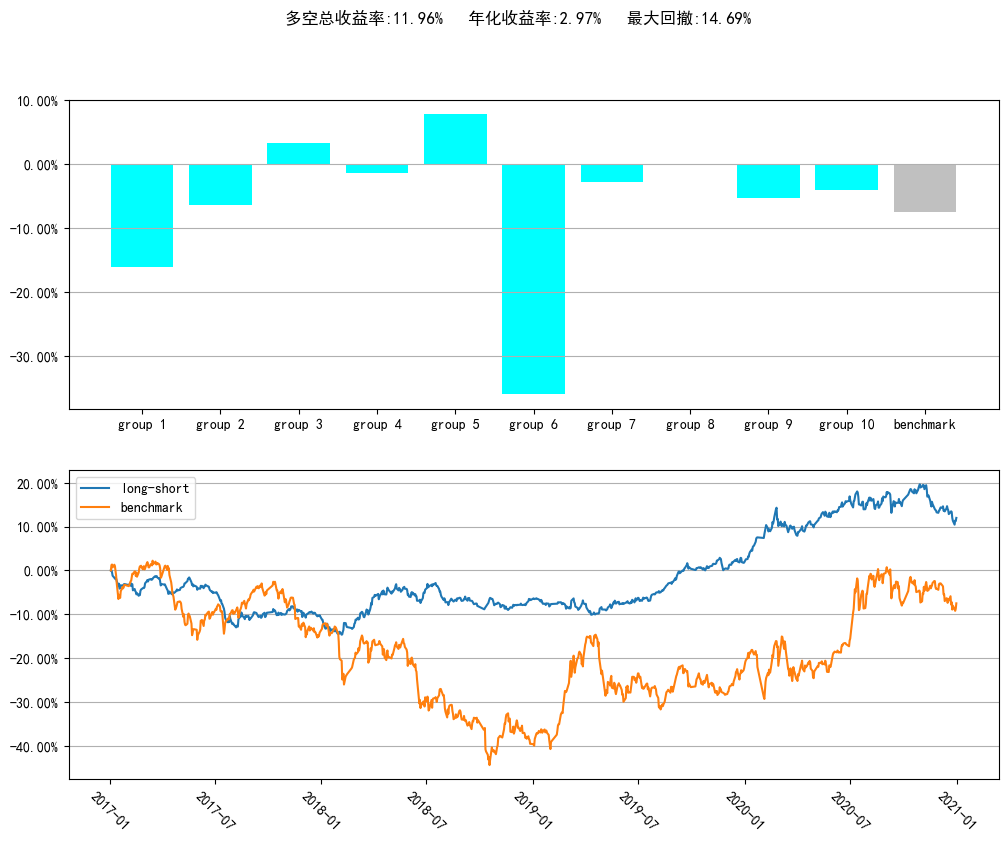

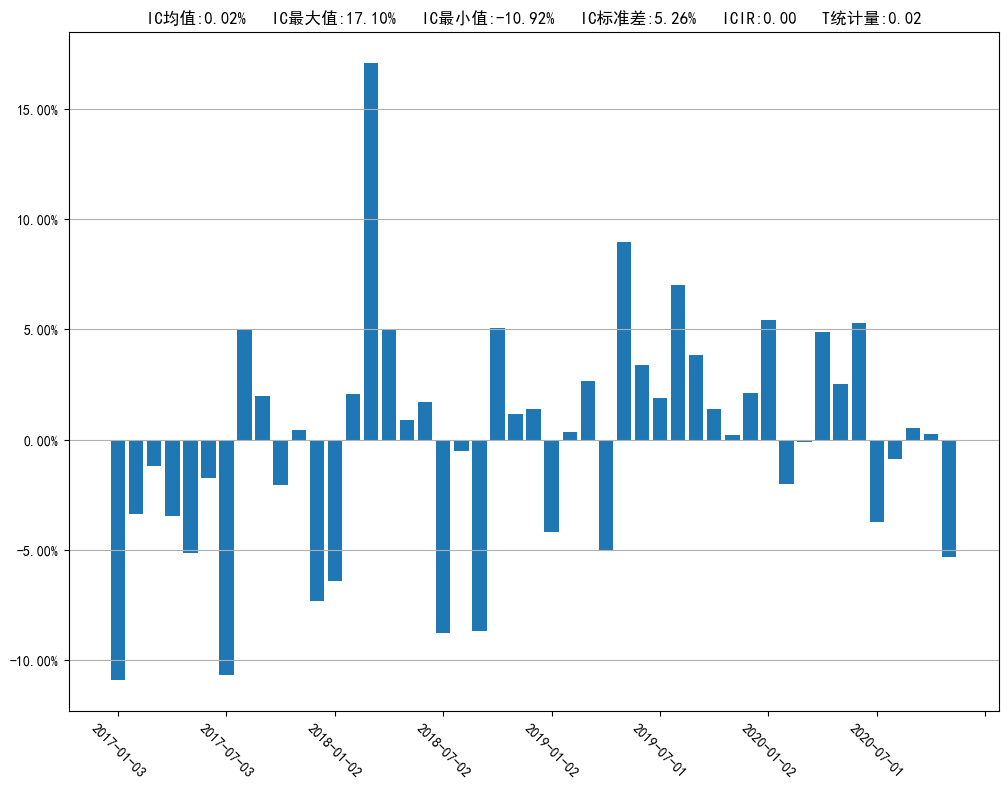

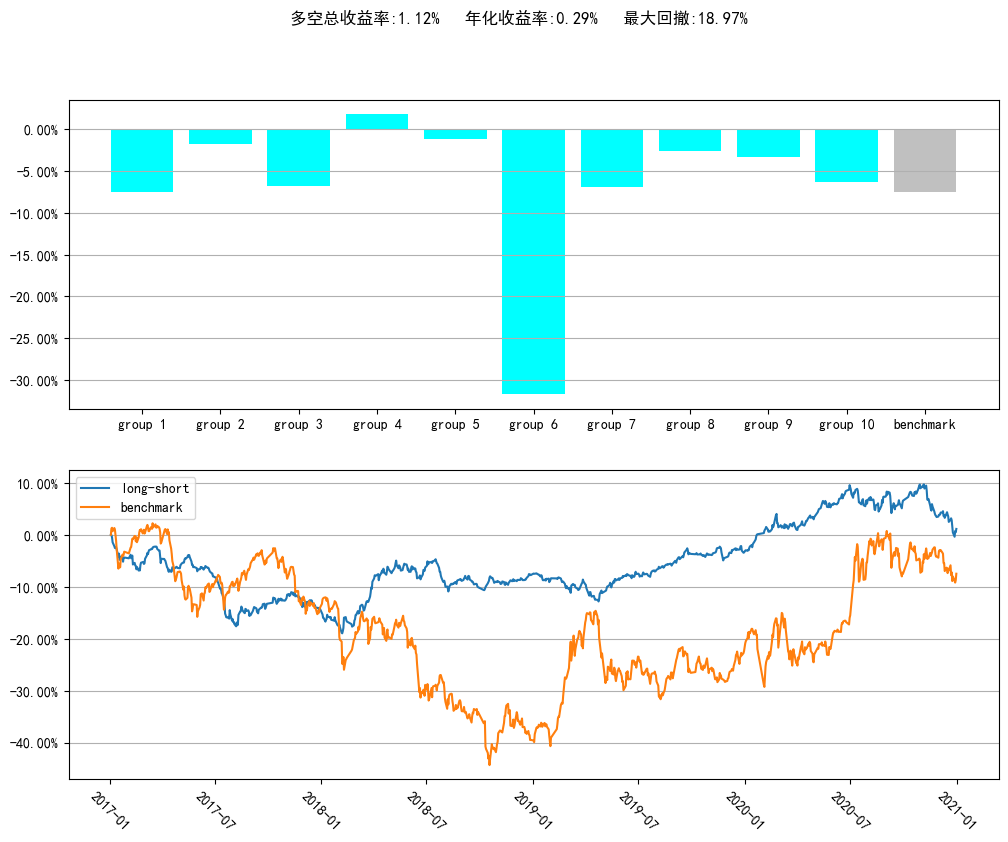

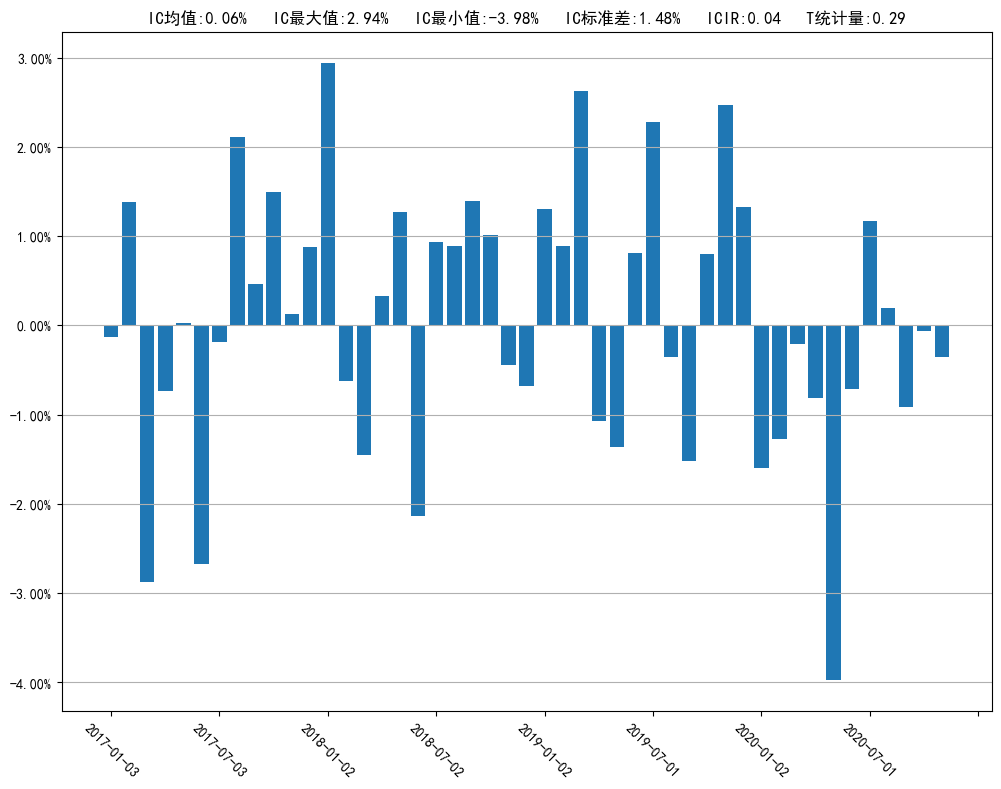

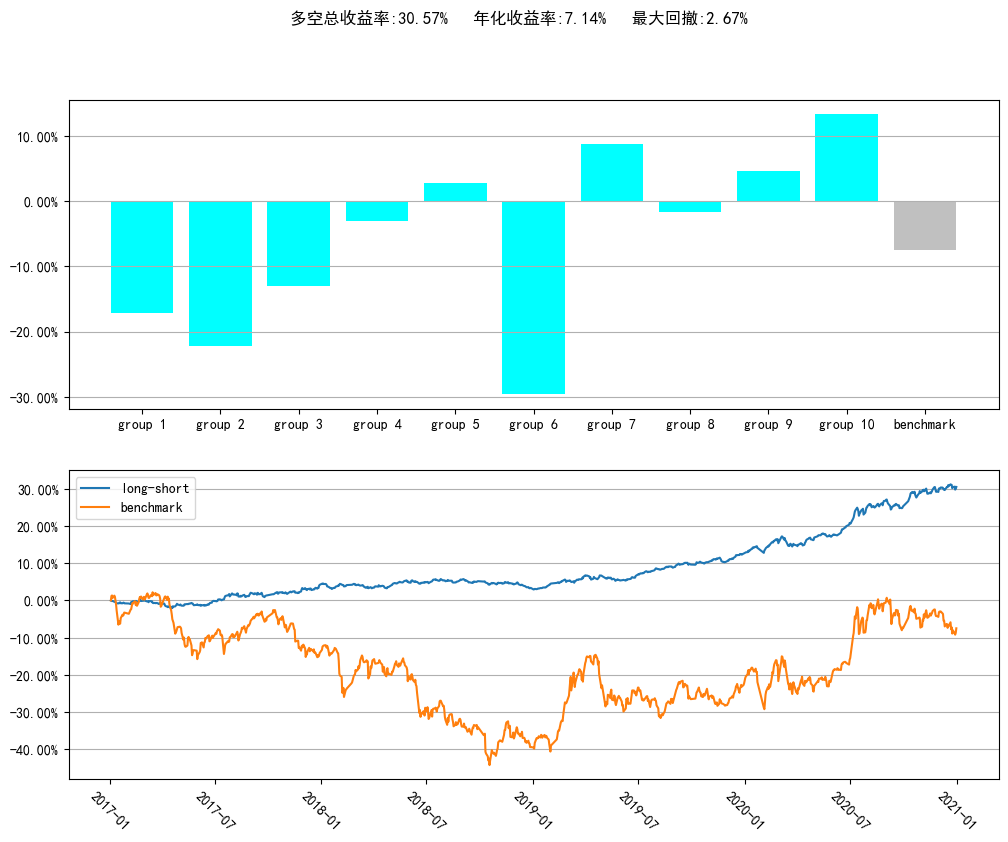

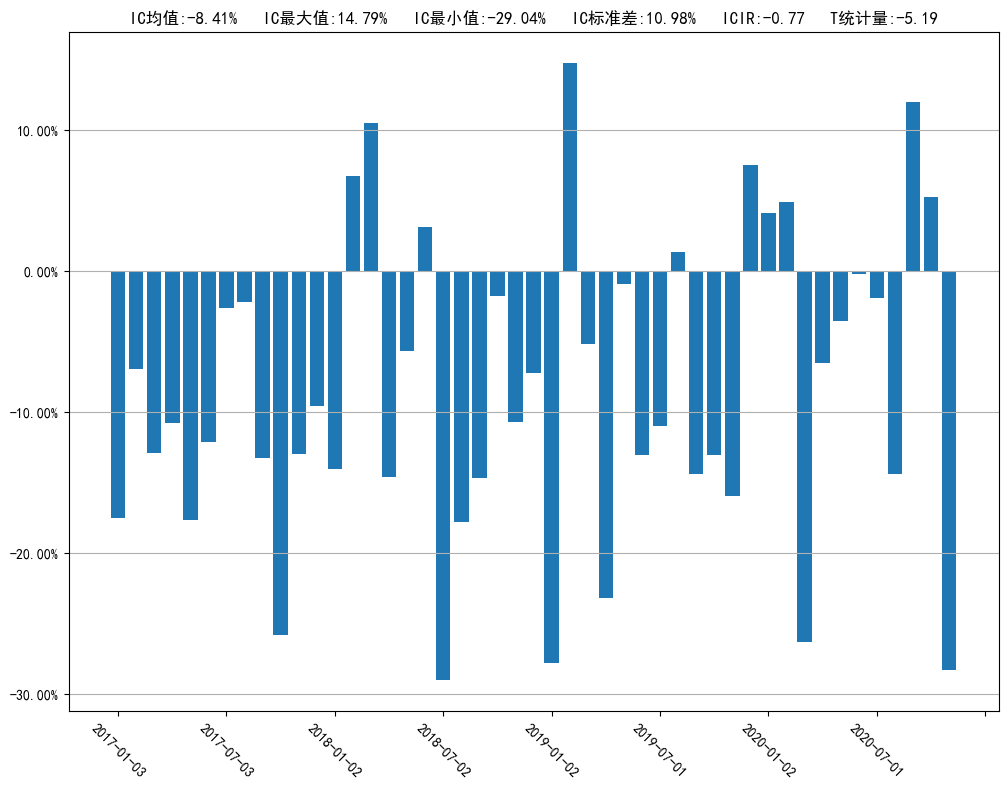

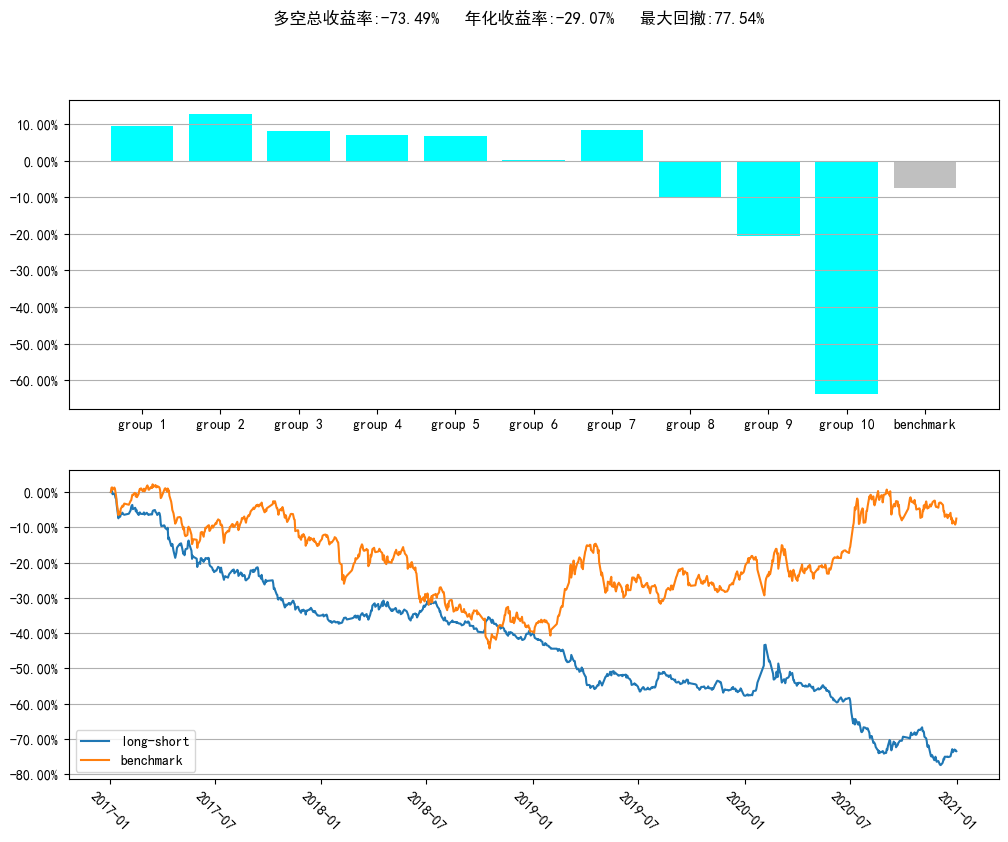

In [3]:
# %load factor_test.py
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
import numpy as np
import dateutil
import time
import os

class Context:
    def __init__(self, start_date, end_date, group_num, frequency, Path_factor):
        self.start_date=start_date  # 回测区间
        self.end_date=end_date
        self.td=None    # 此时日期：%Y-%m-%d
        self.N=None  # 资产数目
        self.group_num=group_num # 因子组数
        self.freq=frequency # 调仓频率:日频'd',周频'w',月频'm',财报公布期(5,9,11月)'f',每n个交易日n(int)
        self.pos_matrix=None   # 仓位矩阵
        self.net_value=None # 各组+基准净值
        self.net_value_left=None    # 当前各组合剩余净值
        self.last_td_mark=None
        self.history={}    # 历史换仓数据：换仓时点、换仓次数、IC、因子值、价格、股票池、仓位

        self.Path_trade_day=None
        self.trade_day=None # 交易日数据
        self.Path_factor=Path_factor
        self.factor=None # 因子数据
        self.Path_price=None
        self.price=None # 股票后复权价格数据
        self.Path_ST=None
        self.ST=None # 股票是否ST或退市，是为1，否为0
        self.Path_suspension=None
        self.suspension=None # 股票是否停复牌，是为1，否为0
        self.Path_over1year=None
        self.over1year=None # 股票是否上市超过1年，是为1，否为0

def initialize(context):
    # 读取信息
    context.Path_trade_day="./otherdata/trade_day.csv"
    context.Path_price="./otherdata/ElementaryFactor-复权收盘价.csv"
    context.Path_ST="./otherdata/ElementaryFactor-ST.csv"
    context.Path_suspension="./otherdata/ElementaryFactor-停复牌.csv"
    context.Path_over1year="./otherdata/ElementaryFactor-上市超过一年.csv"
    # 交易日信息
    context.trade_day=pd.read_csv(context.Path_trade_day,parse_dates=['datetime'],index_col=['datetime'])
    context.trade_day=context.trade_day[context.start_date:context.end_date].index
    # 股价信息
    context.price=pd.read_csv(context.Path_price,parse_dates=['datetime'],index_col=['datetime'])
    context.price=context.price[context.start_date:context.end_date]
    # ST股
    context.ST=pd.read_csv(context.Path_ST,parse_dates=['datetime'],index_col=['datetime'])
    context.ST=context.ST[context.start_date:context.end_date]
    # 是否停牌
    context.suspension=pd.read_csv(context.Path_suspension,parse_dates=['datetime'],index_col=['datetime'])
    context.suspension=context.suspension[context.start_date:context.end_date]
    # 上市满一年
    context.over1year=pd.read_csv(context.Path_over1year,parse_dates=['datetime'],index_col=['datetime'])
    context.over1year=context.over1year[context.start_date:context.end_date]

    # 因子信息，“日期*code”形式
    context.factor=pd.read_csv(context.Path_factor,parse_dates=[0],index_col=[0])
    context.factor=context.factor[context.start_date:context.end_date]
        
    if isinstance(context.freq,int):
        context.last_td_mark=0
    context.N=context.factor.shape[1]
    # 净值矩阵初始化
    group_col=['group '+str(i+1) for i in range(context.group_num)]
    group_col.append('benchmark')
    context.net_value=pd.DataFrame(index=context.trade_day,columns=group_col)
    context.net_value.iloc[0,:]=1   # 设置初始各组资产为1
    # 历史换仓数据
    context.history={'td':[],'times':0,'IC':[],'factor':[],'price':[],'tradable':[],'position':[]}

def rebalance(context):
    # 筛选股票池，去掉ST、上市不满一年、不在市的股票
    td_ST=context.ST.loc[context.td,:].values
    td_suspension=context.suspension.loc[context.td,:].values
    td_over1year=context.over1year.loc[context.td,:].values
    # 得到可交易股票的矩阵
    tradable_matrix=(1-td_ST)*(1-td_suspension)*td_over1year
    # 用在市公司因子值的均值填充NaN
    f=context.factor.loc[context.td,:]
    f_rank=f.rank(method='first').values   # 使用rank排序，防止组间分布不均
    f_value=f_rank[tradable_matrix==1]
    f[np.isnan(f_rank)]=np.nanmean(f.values)
    f_rank[np.isnan(f_rank)]=np.nanmean(f_value)
    f_value=f_rank[tradable_matrix==1]   # 获取更新后的可交易因子值
    # 计算权重矩阵
    context.pos_matrix=np.zeros((context.N,context.group_num+1))
    for g in range(context.group_num):
        V_min=np.percentile(f_value,100*g/context.group_num,interpolation='linear')
        V_max=np.percentile(f_value,100*(g+1)/context.group_num,interpolation='linear')
        if g+1 == context.group_num:
            context.pos_matrix[:,g][(f_rank>=V_min) & (f_rank<=V_max)]=context.net_value_left[g]
        else:
            context.pos_matrix[:,g][(f_rank>=V_min) & (f_rank<V_max)]=context.net_value_left[g]
    context.pos_matrix[:,context.group_num][tradable_matrix==1]=context.net_value_left[context.group_num]
    # 去掉不在市的权重
    context.pos_matrix=context.pos_matrix*tradable_matrix.reshape([context.N,1])
    # 组内等权
    context.pos_matrix=context.pos_matrix/np.count_nonzero(context.pos_matrix,axis=0)
    # 每只股票的仓位=现金比例/股票价格
    for g in range(context.group_num+1):
        context.pos_matrix[:,g]=context.pos_matrix[:,g]/context.price.loc[context.td,:].values
    context.pos_matrix[np.isnan(context.pos_matrix)]=0

    # 存储换仓数据
    context.history['td'].append(context.td)
    context.history['times']+=1
    context.history['factor'].append(f.values)
    context.history['price'].append(context.price.loc[context.td,:].values)
    context.history['tradable'].append(tradable_matrix)
    context.history['position'].append(context.pos_matrix)
    # 计算上次换仓IC
    if context.last_td_mark:
        # 初次建仓不计算
        stock_return=(context.history['price'][-1]-context.history['price'][-2])/context.history['price'][-2]
        stock_return=stock_return[context.history['tradable'][-2]==1]
        stock_return[np.isnan(stock_return)]=0  # i或i-1任一期价格不存在设定收益率为0
        factor=context.history['factor'][-2][context.history['tradable'][-2]==1]
        corr=np.corrcoef(stock_return,factor)
        context.history['IC'].append(corr[0,1])

def MaxDrawdown(series):
    # 计算最大回撤
    drawdown=np.zeros(len(series))
    for i in range(len(series)-1):
        drawdown[i]=(series.iloc[i]-series.iloc[i+1:].min())/series.iloc[i]
    return drawdown.max()

def summary(context):
    # 可视化
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

    ICIR=np.mean(context.history['IC'])/np.std(context.history['IC'], ddof=1)
    title='IC均值:'+'{:.2%}'.format(np.mean(context.history['IC']))+\
        '   IC最大值:'+'{:.2%}'.format(np.max(context.history['IC']))+\
        '   IC最小值:'+'{:.2%}'.format(np.min(context.history['IC']))+\
        '   IC标准差:'+'{:.2%}'.format(np.std(context.history['IC'], ddof=1))+\
        '   ICIR:'+'{:.2f}'.format(ICIR)+\
        '   T统计量:'+'{:.2f}'.format(ICIR*np.sqrt(context.history['times']-2))
    factor_name=context.Path_factor.split('/')[-1].split('.')[0]
    # IC图
    fig = plt.figure(figsize=(12, 9), dpi=100)
    x_label=[t.strftime('%Y-%m-%d') for t in context.history['td'][:-1]]
    plt.bar(x_label,context.history['IC'])
    if isinstance(context.freq,int):
        plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(int(252/(2*context.freq))))
    elif context.freq == 'd':
        plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(126))
    elif context.freq == 'w':
        plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(26))
    elif context.freq == 'm':
        plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))
    elif context.freq == 'f':
        plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=2))
    plt.grid(axis="y")
    plt.xticks(rotation=-45)
    plt.title(title)
    #plt.show()
    plt.savefig('./result/IC_'+factor_name+'_'+str(context.freq)+'.png')

    # 多空图
    LS=context.net_value['group 10']-context.net_value['group 1']
    td_num=len(context.trade_day)
    Drawdown=MaxDrawdown(1+LS)   # 最大回撤
    year_return=(1+LS[context.end_date])**(252/td_num)-1 # 年化收益率
    title='多空总收益率:'+'{:.2%}'.format(LS[context.end_date])+\
        '   年化收益率:'+'{:.2%}'.format(year_return)+\
        '   最大回撤:'+'{:.2%}'.format(Drawdown)
    fig = plt.figure(figsize=(12, 9), dpi=100)    
    ax = fig.add_subplot(2, 1, 1)
    ax.bar(context.net_value.columns,context.net_value.iloc[-1,:]-1,color=10*['cyan']+['silver'])
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=2))
    plt.grid(axis="y")
    ax = fig.add_subplot(2, 1, 2)
    ax.plot(LS,label='long-short')
    ax.plot(context.net_value['benchmark']-1,label='benchmark')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=2))
    plt.grid(axis="y")
    plt.xticks(rotation=-45)
    ax.legend()
    fig.suptitle(title)
    #plt.show()
    plt.savefig('./result/L-S_'+factor_name+'_'+str(context.freq)+'.png')

def handle_data(context):
    if not context.last_td_mark:
        # 最初建仓
        context.net_value_left=context.net_value.loc[context.td,:].values
        rebalance(context)
    else:
        # 利用仓位矩阵计算净值
        td_price=context.price.loc[context.td,:].fillna(value=0)
        context.net_value.loc[context.td,:]=td_price.dot(context.pos_matrix)
        # 更新剩余净值
        context.net_value_left=context.net_value.loc[context.td,:].values

        rebalance_month=[5,9,11]
        # 调仓
        if isinstance(context.freq,int) and context.last_td_mark == context.freq:
            # 固定交易日换仓
            rebalance(context)
            context.last_td_mark=0
        elif context.freq == 'd':
            # 每日换仓
            rebalance(context)
        elif context.freq == 'w' and (context.td.strftime('%W') != context.last_td_mark):
            # 每周换仓
            rebalance(context)
        elif context.freq == 'm' and (context.td.month != context.last_td_mark):
            # 每月换仓
            rebalance(context)
        elif context.freq == 'f' and (context.td.month in rebalance_month and context.td.month != context.last_td_mark):
            # 5,9,11的第一个交易日换仓,更新仓位矩阵
            rebalance(context)

def run(context):
    initialize(context)
    for td in context.trade_day:
        context.td=td
        handle_data(context)
        # 更改标记，用于判断是否换仓
        if isinstance(context.freq,int):
            context.last_td_mark+=1
        elif context.freq == 'w':
            context.last_td_mark=td.strftime('%W')
        else:
            context.last_td_mark=td.month
    summary(context)



file_path="./factor/"
file_list=os.listdir(file_path)
#file_list=[]
for f in file_list:
    context=Context('20170101', '20201231', 10, 'm', file_path+f)
    run(context)
